The idea is to use DCTR for parameterized reweighting in order to do anomaly detection.  The setting is that there is some feature m where the signal is expected to be resonant.  There are other features x that can be used to enhance signal over background.  In the CWoLa hunting methodology, one can only use features x that don't sculpt a bump (a looser requirement than being independent from m, but clearly that would be sufficient); then a parameteric fit based on the sidebands is used to estimate the background in the signal region.  In this new approach, a DCTR model is used to reweight simulation to data in away from the signal region.  This model is parameterized in m and then interpolated to the signal region.  The reweighted simulation in the signal region can then be used to make a classifier (using x) as well as estimate the background.  There is no need for a sideband fit if the reweighting works well.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


Let's make signal region and sideband regions.

In [2]:
signal = pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
pythia = pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
herwig = pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [3]:
def computemjj_np(event):
    px1 = event[:,0]
    py1 = event[:,1]
    pz1 = event[:,2]
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[:,3]**2)
    
    px2 = event[:,7]
    py2 = event[:,8]
    pz2 = event[:,9]
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[:,10]**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.sqrt(m2)

In [4]:
signal_np = signal.to_numpy()
pythia_np = pythia.to_numpy()
herwig_np = herwig.to_numpy()

In [5]:
mjj_signal = computemjj_np(signal_np)
mjj_pythia = computemjj_np(pythia_np)
mjj_herwig = computemjj_np(herwig_np)

First thing to do is to make some plots of the basic features.

In [6]:
def make_plot(pyth,herw,sig,mybins=np.linspace(1000,10000,100),mylabel="$m_{JJ}$ [GeV]",myname="mjj",myscale=10,dolog=True,donormalize=False):

    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    npmjj,bmjj,_=plt.hist(pyth,bins=mybins,alpha=0.5,label="\"Data\" (Pythia)",density=donormalize)
    nhmjj,_,_=plt.hist(herw,bins=mybins,alpha=0.5,label="Sim. (Herwig)",density=donormalize)
    plt.hist(sig,bins=mybins,histtype='step',color='black',label="Signal",density=donormalize)
    plt.ylabel("Events",fontsize=20)
    if (donormalize):
        plt.ylabel("Normalized to unity",fontsize=20)
        pass
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=20)
    if (dolog):
        plt.yscale('log')
        plt.ylim(1,max(npmjj)*myscale)
        pass
    else:
        plt.ylim(0,max(npmjj)*myscale)
    plt.legend(frameon=False,fontsize=20)

    ax1 = plt.subplot(gs[1])
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(direction="in",which="both")
    ax1.minorticks_on()
    plt.xlabel(r""+mylabel,fontsize=20)
    plt.ylabel("Pythia/\nHerwig",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    plt.axhline(y=1,linewidth=2, color='gray')
    npmjj_unnormalized,_=np.histogram(pyth,bins=mybins)
    nhmjj_unnormalized,_=np.histogram(herw,bins=mybins)    
    plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),npmjj/nhmjj,yerr=(npmjj_unnormalized+nhmjj_unnormalized)**0.5/nhmjj_unnormalized,color='black',fmt='o')
    plt.ylim(0.5,1.5)
    plt.tight_layout()
    plt.savefig("plots/"+myname+".pdf")
    pass

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


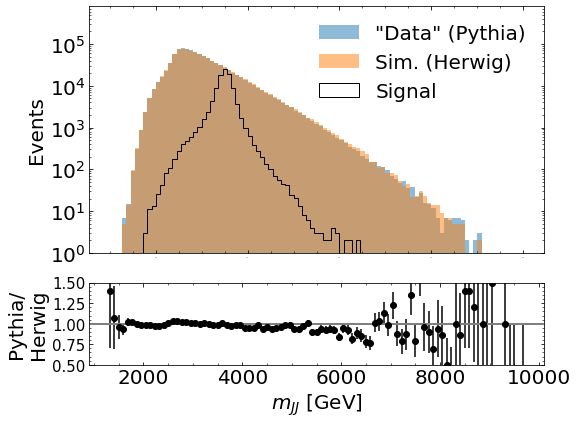

In [7]:
make_plot(mjj_pythia,mjj_herwig,mjj_signal,np.linspace(1000,10000,100),"$m_{JJ}$ [GeV]","mjj")

In [8]:
minmass_pythia = np.array(pythia[['mj1','mj2']].min(axis=1))
maxmass_pythia = np.array(pythia[['mj1','mj2']].max(axis=1))
minmass_herwig = np.array(herwig[['mj1','mj2']].min(axis=1))
maxmass_herwig = np.array(herwig[['mj1','mj2']].max(axis=1))
minmass_signal = np.array(signal[['mj1','mj2']].min(axis=1))
maxmass_signal = np.array(signal[['mj1','mj2']].max(axis=1))

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


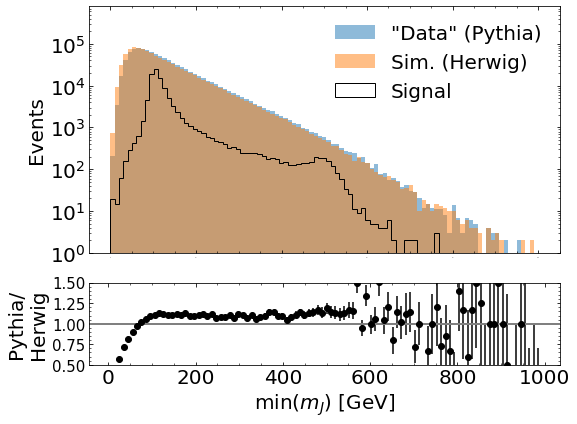

In [9]:
make_plot(minmass_pythia,minmass_herwig,minmass_signal,np.linspace(0,1000,100),"min$(m_{J})$ [GeV]","minmj")

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


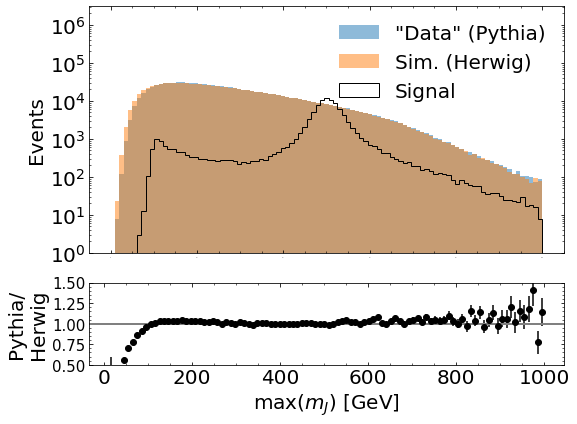

In [10]:
make_plot(maxmass_pythia,maxmass_herwig,maxmass_signal,np.linspace(0,1000,100),"max$(m_{J})$ [GeV]","minmj",100)

In [11]:
tau21A_pythia = pythia_np[:,5]/(0.00001+pythia_np[:,4])
tau21B_pythia = pythia_np[:,12]/(0.00001+pythia_np[:,11])
m1_pythia = pythia_np[:,3]
m2_pythia = pythia_np[:,10]
mymasses_pythia = np.concatenate((np.reshape(m1_pythia,[len(m1_pythia),1]),np.reshape(m2_pythia,[len(m2_pythia),1])),axis=1)
mytaus_pythia = np.concatenate((np.reshape(tau21A_pythia,[len(tau21A_pythia),1]),np.reshape(tau21B_pythia,[len(tau21B_pythia),1])),axis=1)
order_pythia = [np.argmax(mymasses_pythia[i]) for i in range(len(mymasses_pythia))]
tau21a_pythia = [mytaus_pythia[i][order_pythia[i]] for i in range(len(order_pythia))]
tau21b_pythia = [mytaus_pythia[i][1-order_pythia[i]] for i in range(len(order_pythia))]

tau21A_herwig = herwig_np[:,5]/(0.00001+herwig_np[:,4])
tau21B_herwig = herwig_np[:,12]/(0.00001+herwig_np[:,11])
m1_herwig = herwig_np[:,3]
m2_herwig = herwig_np[:,10]
mymasses_herwig = np.concatenate((np.reshape(m1_herwig,[len(m1_herwig),1]),np.reshape(m2_herwig,[len(m2_herwig),1])),axis=1)
mytaus_herwig = np.concatenate((np.reshape(tau21A_herwig,[len(tau21A_herwig),1]),np.reshape(tau21B_herwig,[len(tau21B_herwig),1])),axis=1)
order_herwig = [np.argmax(mymasses_herwig[i]) for i in range(len(mymasses_herwig))]
tau21a_herwig = [mytaus_herwig[i][order_herwig[i]] for i in range(len(order_herwig))]
tau21b_herwig = [mytaus_herwig[i][1-order_herwig[i]] for i in range(len(order_herwig))]

tau21A_signal = signal_np[:,5]/(0.00001+signal_np[:,4])
tau21B_signal = signal_np[:,12]/(0.00001+signal_np[:,11])
m1_signal = signal_np[:,3]
m2_signal = signal_np[:,10]
mymasses_signal = np.concatenate((np.reshape(m1_signal,[len(m1_signal),1]),np.reshape(m2_signal,[len(m2_signal),1])),axis=1)
mytaus_signal = np.concatenate((np.reshape(tau21A_signal,[len(tau21A_signal),1]),np.reshape(tau21B_signal,[len(tau21B_signal),1])),axis=1)
order_signal = [np.argmax(mymasses_signal[i]) for i in range(len(mymasses_signal))]
tau21a_signal = [mytaus_signal[i][order_signal[i]] for i in range(len(order_signal))]
tau21b_signal = [mytaus_signal[i][1-order_signal[i]] for i in range(len(order_signal))]

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]


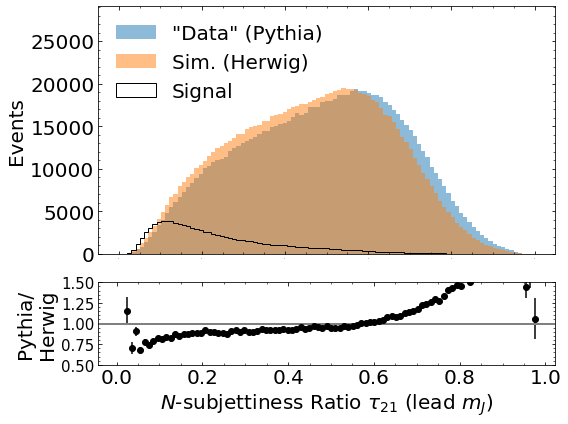

In [12]:
make_plot(tau21a_pythia,tau21a_herwig,tau21a_signal,np.linspace(0,1,100),"$N$-subjettiness Ratio $\\tau_{21}$ (lead $m_{J}$)","maxtau21",1.5,False)

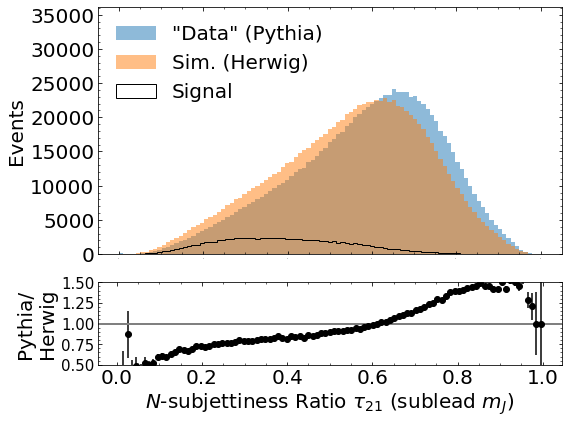

In [13]:
make_plot(tau21b_pythia,tau21b_herwig,tau21b_signal,np.linspace(0,1,100),"$N$-subjettiness Ratio $\\tau_{21}$ (sublead $m_{J}$)","mintau21",1.5,False)

Now, let's prepare the ML input

In [14]:
def rs(x):
    return np.reshape(x,[len(x),1])

In [15]:
x_signal = np.concatenate((rs(maxmass_signal)/1000.,rs(minmass_signal)/1000.,rs(tau21a_signal),rs(tau21b_signal)),axis=1)
x_data = np.concatenate((rs(maxmass_pythia)/1000.,rs(minmass_pythia)/1000.,rs(tau21a_pythia),rs(tau21b_pythia)),axis=1)
x_MC = np.concatenate((rs(maxmass_herwig)/1000.,rs(minmass_herwig)/1000.,rs(tau21a_herwig),rs(tau21b_herwig)),axis=1)

In [16]:
SR_low = 3250
SR_high = 3750

In [17]:
x_SR_signal = x_signal[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
x_SR_data = x_data[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
x_SR_MC = x_MC[(mjj_herwig > SR_low)*(mjj_herwig < SR_high)]

x_SB_signal = x_signal[(mjj_signal < SR_low)+(mjj_signal > SR_high)]
x_SB_data = x_data[(mjj_pythia < SR_low)+(mjj_pythia > SR_high)]
x_SB_MC = x_MC[(mjj_herwig < SR_low)+(mjj_herwig > SR_high)]

First, let's see how well we could do supervised.

In [18]:
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
X = np.concatenate([x_SR_signal,x_SR_data])
Y = np.concatenate([np.ones(len(x_SR_signal)),np.zeros(len(x_SR_data))])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [20]:
model.fit(X_train,Y_train, epochs=5, batch_size=200,validation_data=(X_test,Y_test))

Train on 117218 samples, validate on 117218 samples
Epoch 1/5
117218/117218 [==============================] - 6s 51us/step - loss: 0.3424 - acc: 0.8575 - val_loss: 0.2527 - val_acc: 0.9057
Epoch 2/5
117218/117218 [==============================] - 4s 34us/step - loss: 0.2532 - acc: 0.9047 - val_loss: 0.2206 - val_acc: 0.9167
Epoch 3/5
117218/117218 [==============================] - 4s 34us/step - loss: 0.2362 - acc: 0.9107 - val_loss: 0.2194 - val_acc: 0.9164
Epoch 4/5
117218/117218 [==============================] - 4s 34us/step - loss: 0.2318 - acc: 0.9123 - val_loss: 0.2214 - val_acc: 0.9139
Epoch 5/5
117218/117218 [==============================] - 4s 34us/step - loss: 0.2280 - acc: 0.9132 - val_loss: 0.2100 - val_acc: 0.9210


In [24]:
preds = model.predict(X_test)

In [21]:
preds_signal = model.predict(X_test[Y_test==1])
preds_pythia = model.predict(X_test[Y_test==0])
preds_herwig = model.predict(x_SR_MC)

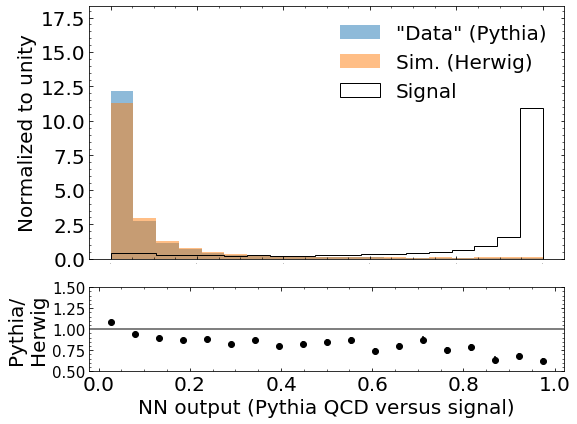

In [22]:
make_plot(preds_pythia,preds_herwig,preds_signal,np.linspace(0,1,20),"NN output (Pythia QCD versus signal)","nnqcdvsignal",1.5,False,True)

0.9667314692629583 19.507405955434812


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


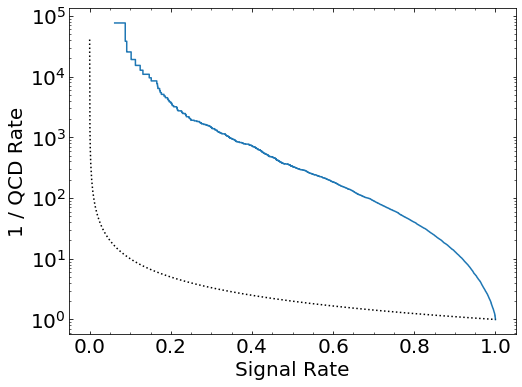

In [25]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
fpr, tpr, _ = roc_curve(Y_test, preds)
print(auc(fpr,tpr),max(tpr/(0.00001+fpr)**0.5))
plt.plot(tpr,1/fpr)
plt.plot(tpr,1/tpr,color="black",ls=":")
#plt.plot([0,1],[1,0],color="black",ls=":")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.yscale("log")
plt.xlabel("Signal Rate",fontsize=20)
plt.ylabel("1 / QCD Rate",fontsize=20)
plt.savefig("plots/ROC_sigvqcd.pdf")

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


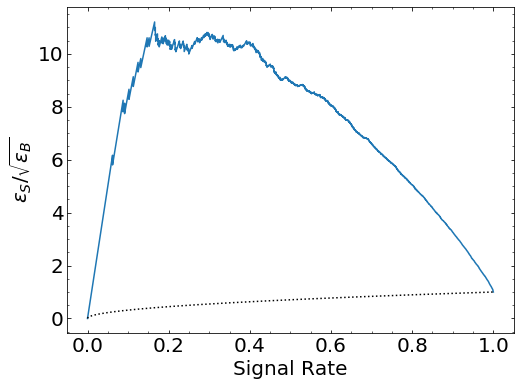

In [26]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.plot(tpr,tpr/(0.0001+fpr)**0.5)
plt.plot(tpr,tpr/tpr**0.5,color="black",ls=':')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Signal Rate",fontsize=20)
plt.ylabel(r"$\epsilon_S/\sqrt{\epsilon_B}$",fontsize=20)
plt.savefig("plots/SIC_sigvqcd.pdf")

In [86]:
from random import shuffle
import time
from keras import backend as K

Nforsig = 5 #was 5
Ntoys = 10 #was 10
Nepochs = 3 #was 5

aucs = []
maxsigs = []
fpr50s = []
sic50s = []
muvals = []

eaucs = []
emaxsigs = []
efpr50s = []
esic50s = []

for k in range(2,12):
    #Randomly divide the background in half.  Half is used for testing and half is used for training.  Of the half
    #used for training, divide it in half again - half will have some signal added and half will not.
    #Randomly take a fraction 1/2^k of the signal to add to one part of the background.
    
    indx = np.array(range(len(x_SR_data)))
    shuffle(indx)
    testindx = indx[int(0.5*len(indx)):-1]
    
    indx_signal = np.array(range(len(x_SR_signal)))
    shuffle(indx_signal)
    testindx_signal = indx_signal[int(0.5*len(indx_signal)):-1]  
    
    mu = 1./2**k
    sig_number = int(mu*len(indx)*0.25)
    
    aucs_vec = []
    mymaxsic_vec = []
    myfpr50_vec = []
    mysic50_vec = []
    
    for outerloop in range(Nforsig):
    
        K.clear_session()
        t0 = time.time()
        models = {}
        for itoy in range(Ntoys):
            indx2 = indx[0:int(0.5*len(indx))]
            shuffle(indx2)
            fakeMCindx = indx2[0:int(0.5*len(indx2))]
            fakeDataindx = indx2[int(0.5*len(indx2)):-1]
            injectedindx_signal = indx_signal[0:sig_number]
            X = np.concatenate([x_SR_signal[injectedindx_signal],x_SR_data[fakeMCindx],x_SR_data[fakeDataindx]])
            Y = np.concatenate([np.ones(len(x_SR_signal[injectedindx_signal])),np.zeros(len(x_SR_data[fakeMCindx])),np.ones(len(x_SR_data[fakeDataindx]))])

            models[itoy] = Sequential()
            models[itoy].add(Dense(64, input_dim=4, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(64, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(64, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(64, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(1, activation='sigmoid'))
            models[itoy].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            #models[itoy].summary()

            models[itoy].fit(X,Y, epochs=Nepochs, batch_size=200)
            pass

        Xpure = np.concatenate([x_SR_data[testindx],x_SR_signal[testindx_signal]])
        Ypure = np.concatenate([np.zeros(len(x_SR_data[testindx])),np.ones(len(x_SR_signal[testindx_signal]))])

        mypreds = []
        for itoy in range(Ntoys):
            print(itoy)
            mypreds+=[models[itoy].predict(Xpure)[:,0]]
            pass  
        mypreds = np.array(mypreds)
        preds = [stats.trim_mean(mypreds.T[i], 0.2) for i in range(len(mypreds.T))] #truncated mean    
 
        fpr, tpr, _ = roc_curve(Ypure, preds)
        sic = tpr/(0.0001+fpr)**0.5
        myauc = auc(fpr,tpr)
        mymaxsic = max(sic)
        myfpr50 = fpr[np.where(tpr>0.5)[0][0]]
        mysic50 = sic[np.where(tpr>0.5)[0][0]]
        
        aucs_vec += [myauc]
        mymaxsic_vec += [mymaxsic]
        myfpr50_vec += [myfpr50]
        mysic50_vec += [mysic50]
        t1 = time.time()
        print("    check time:",t1-t0,mu,outerloop,len(Xpure))
        pass
    
    muvals+=[mu]    
    aucs+=[np.mean(aucs_vec)]
    maxsigs+=[np.mean(mymaxsic_vec)]
    fpr50s = [np.mean(myfpr50_vec)]
    sic50s = [np.mean(mysic50_vec)]

    eaucs+=[np.std(aucs_vec)]
    emaxsigs+=[np.std(mymaxsic_vec)]
    efpr50s = [np.std(myfpr50_vec)]
    esic50s = [np.std(mysic50_vec)]
    
    f = open('pythia_nodctr.txt','a+')
    f.write(str(mu)+" "+str(np.mean(aucs_vec))+" "+str(np.mean(mymaxsic_vec))+" "+str(np.mean(myfpr50_vec))+" "+str(np.mean(mysic50_vec))+ " "+str(np.std(aucs_vec))+" "+str(np.std(mymaxsic_vec))+" "+str(np.std(myfpr50_vec))+" "+str(np.std(mysic50_vec))+"\n")
    f.close()
    
    print(mu,np.mean(aucs_vec),np.mean(mymaxsic_vec),sig_number)
    pass

Epoch 1/3
85874/85874 [==============================] - 4s 43us/step - loss: 0.6688 - acc: 0.5528
Epoch 2/3
85874/85874 [==============================] - 2s 29us/step - loss: 0.6583 - acc: 0.5573
Epoch 3/3
85874/85874 [==============================] - 2s 28us/step - loss: 0.6539 - acc: 0.5563
Epoch 1/3
85874/85874 [==============================] - 4s 45us/step - loss: 0.6714 - acc: 0.5545
Epoch 2/3
85874/85874 [==============================] - 2s 29us/step - loss: 0.6599 - acc: 0.5553
Epoch 3/3
85874/85874 [==============================] - 2s 29us/step - loss: 0.6533 - acc: 0.5548
Epoch 1/3
85874/85874 [==============================] - 4s 49us/step - loss: 0.6680 - acc: 0.5560
Epoch 2/3
85874/85874 [==============================] - 3s 30us/step - loss: 0.6585 - acc: 0.5554
Epoch 3/3
85874/85874 [==============================] - 3s 30us/step - loss: 0.6533 - acc: 0.5556
Epoch 1/3
85874/85874 [==============================] - 5s 53us/step - loss: 0.6699 - acc: 0.5535
Epoch 2/3


81103/81103 [==============================] - 2s 30us/step - loss: 0.6804 - acc: 0.5274
Epoch 1/3
81103/81103 [==============================] - 4s 53us/step - loss: 0.6867 - acc: 0.5267
Epoch 2/3
81103/81103 [==============================] - 2s 29us/step - loss: 0.6814 - acc: 0.5268
Epoch 3/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6782 - acc: 0.5283
Epoch 1/3
81103/81103 [==============================] - 4s 55us/step - loss: 0.6860 - acc: 0.5258
Epoch 2/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6812 - acc: 0.5274
Epoch 3/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6788 - acc: 0.5277
Epoch 1/3
81103/81103 [==============================] - 5s 57us/step - loss: 0.6860 - acc: 0.5264
Epoch 2/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6814 - acc: 0.5298
Epoch 3/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6787 - acc: 0.5297
Epoch 1/3
81103/8110

78718/78718 [==============================] - 6s 71us/step - loss: 0.6914 - acc: 0.5168
Epoch 2/3
78718/78718 [==============================] - 3s 32us/step - loss: 0.6898 - acc: 0.5142
Epoch 3/3
78718/78718 [==============================] - 3s 33us/step - loss: 0.6891 - acc: 0.5145
Epoch 1/3
78718/78718 [==============================] - 6s 73us/step - loss: 0.6917 - acc: 0.5146
Epoch 2/3
78718/78718 [==============================] - 2s 30us/step - loss: 0.6901 - acc: 0.5145
Epoch 3/3
78718/78718 [==============================] - 2s 30us/step - loss: 0.6885 - acc: 0.5152
Epoch 1/3
78718/78718 [==============================] - 6s 76us/step - loss: 0.6921 - acc: 0.5124
Epoch 2/3
78718/78718 [==============================] - 2s 31us/step - loss: 0.6905 - acc: 0.5140
Epoch 3/3
78718/78718 [==============================] - 2s 30us/step - loss: 0.6893 - acc: 0.5139
0
1
2
3
4
5
6
7
8
9
    check time: 160.53711771965027 0.0625 0 117216
Epoch 1/3
78718/78718 [=========================

77525/77525 [==============================] - 2s 29us/step - loss: 0.6929 - acc: 0.5058
Epoch 3/3
77525/77525 [==============================] - 2s 29us/step - loss: 0.6927 - acc: 0.5055
Epoch 1/3
77525/77525 [==============================] - 3s 43us/step - loss: 0.6930 - acc: 0.5059
Epoch 2/3
77525/77525 [==============================] - 2s 29us/step - loss: 0.6926 - acc: 0.5082
Epoch 3/3
77525/77525 [==============================] - 2s 29us/step - loss: 0.6923 - acc: 0.5075
Epoch 1/3
77525/77525 [==============================] - 3s 45us/step - loss: 0.6932 - acc: 0.5060
Epoch 2/3
77525/77525 [==============================] - 2s 29us/step - loss: 0.6929 - acc: 0.5065
Epoch 3/3
77525/77525 [==============================] - 2s 29us/step - loss: 0.6924 - acc: 0.5080
Epoch 1/3
77525/77525 [==============================] - 4s 49us/step - loss: 0.6931 - acc: 0.5048
Epoch 2/3
77525/77525 [==============================] - 2s 30us/step - loss: 0.6927 - acc: 0.5064
Epoch 3/3
77525/7752

76929/76929 [==============================] - 4s 58us/step - loss: 0.6933 - acc: 0.5042
Epoch 2/3
76929/76929 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5012
Epoch 3/3
76929/76929 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5037
Epoch 1/3
76929/76929 [==============================] - 5s 62us/step - loss: 0.6933 - acc: 0.5014
Epoch 2/3
76929/76929 [==============================] - 2s 30us/step - loss: 0.6933 - acc: 0.5007
Epoch 3/3
76929/76929 [==============================] - 2s 30us/step - loss: 0.6931 - acc: 0.5016
Epoch 1/3
76929/76929 [==============================] - 5s 66us/step - loss: 0.6932 - acc: 0.5052
Epoch 2/3
76929/76929 [==============================] - 2s 31us/step - loss: 0.6931 - acc: 0.5034
Epoch 3/3
76929/76929 [==============================] - 2s 30us/step - loss: 0.6930 - acc: 0.5036
Epoch 1/3
76929/76929 [==============================] - 5s 69us/step - loss: 0.6934 - acc: 0.5009
Epoch 2/3
76929/7692

76631/76631 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5010
Epoch 3/3
76631/76631 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5020
Epoch 1/3
76631/76631 [==============================] - 5s 64us/step - loss: 0.6933 - acc: 0.4966
Epoch 2/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6932 - acc: 0.5017
Epoch 3/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6932 - acc: 0.5018
Epoch 1/3
76631/76631 [==============================] - 5s 66us/step - loss: 0.6934 - acc: 0.5005
Epoch 2/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6932 - acc: 0.5028
Epoch 3/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6932 - acc: 0.5038
0
1
2
3
4
5
6
7
8
9
    check time: 151.39075994491577 0.0078125 1 117216
Epoch 1/3
76631/76631 [==============================] - 3s 40us/step - loss: 0.6933 - acc: 0.4995
Epoch 2/3
76631/76631 [======================

76482/76482 [==============================] - 2s 29us/step - loss: 0.6932 - acc: 0.5021
Epoch 1/3
76482/76482 [==============================] - 4s 49us/step - loss: 0.6933 - acc: 0.5004
Epoch 2/3
76482/76482 [==============================] - 2s 31us/step - loss: 0.6932 - acc: 0.5027
Epoch 3/3
76482/76482 [==============================] - 2s 32us/step - loss: 0.6932 - acc: 0.5026
Epoch 1/3
76482/76482 [==============================] - 4s 51us/step - loss: 0.6934 - acc: 0.5000
Epoch 2/3
76482/76482 [==============================] - 2s 32us/step - loss: 0.6932 - acc: 0.5016
Epoch 3/3
76482/76482 [==============================] - 2s 32us/step - loss: 0.6932 - acc: 0.4993
Epoch 1/3
76482/76482 [==============================] - 4s 54us/step - loss: 0.6934 - acc: 0.4991
Epoch 2/3
76482/76482 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5003
Epoch 3/3
76482/76482 [==============================] - 2s 29us/step - loss: 0.6932 - acc: 0.5024
Epoch 1/3
76482/7648

76407/76407 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5004
Epoch 3/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.4977
Epoch 1/3
76407/76407 [==============================] - 4s 57us/step - loss: 0.6934 - acc: 0.4987
Epoch 2/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5007
Epoch 3/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6933 - acc: 0.5006
Epoch 1/3
76407/76407 [==============================] - 5s 60us/step - loss: 0.6933 - acc: 0.4993
Epoch 2/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5015
Epoch 3/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5011
Epoch 1/3
76407/76407 [==============================] - 5s 63us/step - loss: 0.6934 - acc: 0.4979
Epoch 2/3
76407/76407 [==============================] - 2s 31us/step - loss: 0.6932 - acc: 0.5015
Epoch 3/3
76407/7640

76370/76370 [==============================] - 3s 44us/step - loss: 0.6933 - acc: 0.5007
Epoch 2/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.4987
Epoch 3/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6933 - acc: 0.5004
Epoch 1/3
76370/76370 [==============================] - 4s 50us/step - loss: 0.6933 - acc: 0.5003
Epoch 2/3
76370/76370 [==============================] - 2s 29us/step - loss: 0.6932 - acc: 0.5002
Epoch 3/3
76370/76370 [==============================] - 2s 29us/step - loss: 0.6932 - acc: 0.5005
Epoch 1/3
76370/76370 [==============================] - 4s 47us/step - loss: 0.6934 - acc: 0.4997
Epoch 2/3
76370/76370 [==============================] - 2s 29us/step - loss: 0.6932 - acc: 0.5009
Epoch 3/3
76370/76370 [==============================] - 2s 29us/step - loss: 0.6932 - acc: 0.4995
Epoch 1/3
76370/76370 [==============================] - 4s 49us/step - loss: 0.6933 - acc: 0.5000
Epoch 2/3
76370/7637

Epoch 3/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.4986
Epoch 1/3
76351/76351 [==============================] - 5s 63us/step - loss: 0.6933 - acc: 0.5001
Epoch 2/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5022
Epoch 3/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6932 - acc: 0.5010
Epoch 1/3
76351/76351 [==============================] - 5s 66us/step - loss: 0.6933 - acc: 0.5032
Epoch 2/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6933 - acc: 0.4967
Epoch 3/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6932 - acc: 0.4996
Epoch 1/3
76351/76351 [==============================] - 6s 72us/step - loss: 0.6932 - acc: 0.5018
Epoch 2/3
76351/76351 [==============================] - 2s 32us/step - loss: 0.6932 - acc: 0.4966
Epoch 3/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6932 - acc: 0.4975
Epoch 1/3


In [148]:
print(len(x_SR_data))
print(len(x_SR_MC))
print(len(x_SB_data))
print(len(x_SB_MC))

152668
153708
847331
846291


In [97]:
from random import shuffle

#This one is with Herwig instead of Pythia as the MC.

Nforsig = 5 #was 5
Ntoys = 10 #was 10
Nepochs = 3 #was 5

haucs = []
hmaxsigs = []
hfpr50s = []
hsic50s = []
hmuvals = []

heaucs = []
hemaxsigs = []
hefpr50s = []
hesic50s = []

for k in range(2,12):
    #Randomly divide the background in half.  Half is used for testing and half is used for training.  Of the half
    #used for training, divide it in half again - half will have some signal added and half will not.
    #Randomly take a fraction 1/2^k of the signal to add to one part of the background.
    
    indx = np.array(range(len(x_SR_data)))
    shuffle(indx)
    testindx = indx[int(0.5*len(indx)):-1]
    
    indx_signal = np.array(range(len(x_SR_signal)))
    shuffle(indx_signal)
    testindx_signal = indx_signal[int(0.5*len(indx_signal)):-1]  
    
    mu = 1./2**k
    sig_number = int(mu*len(indx)*0.25)
    
    aucs_vec = []
    mymaxsic_vec = []
    myfpr50_vec = []
    mysic50_vec = []
    
    for outerloop in range(Nforsig):
    
        K.clear_session()
        t0 = time.time()
        models = {}
        for itoy in range(Ntoys):
            indx2 = indx[0:int(0.5*len(indx))]
            shuffle(indx2)
            fakeMCindx = indx2[0:int(0.5*len(indx2))]
            fakeDataindx = indx2[int(0.5*len(indx2)):-1]
            injectedindx_signal = indx_signal[0:sig_number]
            X = np.concatenate([x_SR_signal[injectedindx_signal],x_SR_MC[fakeMCindx],x_SR_data[fakeDataindx]])
            Y = np.concatenate([np.ones(len(x_SR_signal[injectedindx_signal])),np.zeros(len(x_SR_MC[fakeMCindx])),np.ones(len(x_SR_data[fakeDataindx]))])

            models[itoy] = Sequential()
            models[itoy].add(Dense(64, input_dim=4, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(64, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(64, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(64, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(1, activation='sigmoid'))
            models[itoy].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            models[itoy].fit(X,Y, epochs=Nepochs, batch_size=200)
            pass

        Xpure = np.concatenate([x_SR_data[testindx],x_SR_signal[testindx_signal]])
        Ypure = np.concatenate([np.zeros(len(x_SR_data[testindx])),np.ones(len(x_SR_signal[testindx_signal]))])

        mypreds = []
        for itoy in range(Ntoys):
            print(itoy)
            mypreds+=[models[itoy].predict(Xpure)[:,0]]
            pass  
        mypreds = np.array(mypreds)
        preds = [stats.trim_mean(mypreds.T[i], 0.2) for i in range(len(mypreds.T))] #truncated mean    
 
        fpr, tpr, _ = roc_curve(Ypure, preds)
        sic = tpr/(0.0001+fpr)**0.5
        myauc = auc(fpr,tpr)
        mymaxsic = max(sic)
        myfpr50 = fpr[np.where(tpr>0.5)[0][0]]
        mysic50 = sic[np.where(tpr>0.5)[0][0]]
        
        aucs_vec += [myauc]
        mymaxsic_vec += [mymaxsic]
        myfpr50_vec += [myfpr50]
        mysic50_vec += [mysic50]
        t1 = time.time()
        print("    check time:",t1-t0,mu,outerloop,len(Xpure))
        pass
    
    hmuvals+=[mu]    
    haucs+=[np.mean(aucs_vec)]
    hmaxsigs+=[np.mean(mymaxsic_vec)]
    hfpr50s = [np.mean(myfpr50_vec)]
    hsic50s = [np.mean(mysic50_vec)]

    heaucs+=[np.std(aucs_vec)]
    hemaxsigs+=[np.std(mymaxsic_vec)]
    hefpr50s = [np.std(myfpr50_vec)]
    hesic50s = [np.std(mysic50_vec)]
    
    f = open('herwig_nodctr.txt','a+')
    f.write(str(mu)+" "+str(np.mean(aucs_vec))+" "+str(np.mean(mymaxsic_vec))+" "+str(np.mean(myfpr50_vec))+" "+str(np.mean(mysic50_vec))+ " "+str(np.std(aucs_vec))+" "+str(np.std(mymaxsic_vec))+" "+str(np.std(myfpr50_vec))+" "+str(np.std(mysic50_vec))+"\n")
    f.close()
    
    print(mu,np.mean(aucs_vec),np.mean(mymaxsic_vec),sig_number)
    pass

Epoch 1/3
85874/85874 [==============================] - 4s 41us/step - loss: 0.6755 - acc: 0.5610
Epoch 2/3
85874/85874 [==============================] - 3s 30us/step - loss: 0.6597 - acc: 0.5800
Epoch 3/3
85874/85874 [==============================] - 3s 31us/step - loss: 0.6502 - acc: 0.5892
Epoch 1/3
85874/85874 [==============================] - 4s 45us/step - loss: 0.6762 - acc: 0.5610
Epoch 2/3
85874/85874 [==============================] - 2s 29us/step - loss: 0.6577 - acc: 0.5816
Epoch 3/3
85874/85874 [==============================] - 3s 29us/step - loss: 0.6495 - acc: 0.5883
Epoch 1/3
85874/85874 [==============================] - 4s 44us/step - loss: 0.6754 - acc: 0.5602
Epoch 2/3
85874/85874 [==============================] - 3s 29us/step - loss: 0.6602 - acc: 0.5815
Epoch 3/3
85874/85874 [==============================] - 3s 30us/step - loss: 0.6495 - acc: 0.5889
Epoch 1/3
85874/85874 [==============================] - 4s 46us/step - loss: 0.6754 - acc: 0.5594
Epoch 2/3


81103/81103 [==============================] - 2s 30us/step - loss: 0.6725 - acc: 0.5719
Epoch 1/3
81103/81103 [==============================] - 6s 78us/step - loss: 0.6881 - acc: 0.5390
Epoch 2/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6814 - acc: 0.5603
Epoch 3/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6764 - acc: 0.5632
Epoch 1/3
81103/81103 [==============================] - 5s 60us/step - loss: 0.6878 - acc: 0.5398
Epoch 2/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6811 - acc: 0.5586
Epoch 3/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6732 - acc: 0.5660
Epoch 1/3
81103/81103 [==============================] - 5s 64us/step - loss: 0.6875 - acc: 0.5445
Epoch 2/3
81103/81103 [==============================] - 2s 30us/step - loss: 0.6801 - acc: 0.5605
Epoch 3/3
81103/81103 [==============================] - 2s 31us/step - loss: 0.6729 - acc: 0.5677
Epoch 1/3
81103/8110

78718/78718 [==============================] - 5s 69us/step - loss: 0.6904 - acc: 0.5304
Epoch 2/3
78718/78718 [==============================] - 2s 30us/step - loss: 0.6858 - acc: 0.5518
Epoch 3/3
78718/78718 [==============================] - 2s 31us/step - loss: 0.6838 - acc: 0.5558
Epoch 1/3
78718/78718 [==============================] - 6s 72us/step - loss: 0.6905 - acc: 0.5274
Epoch 2/3
78718/78718 [==============================] - 2s 31us/step - loss: 0.6867 - acc: 0.5502
Epoch 3/3
78718/78718 [==============================] - 2s 32us/step - loss: 0.6849 - acc: 0.5555
Epoch 1/3
78718/78718 [==============================] - 6s 79us/step - loss: 0.6904 - acc: 0.5281
Epoch 2/3
78718/78718 [==============================] - 3s 34us/step - loss: 0.6867 - acc: 0.5478
Epoch 3/3
78718/78718 [==============================] - 3s 34us/step - loss: 0.6851 - acc: 0.5529
0
1
2
3
4
5
6
7
8
9
    check time: 161.44925093650818 0.0625 0 117216
Epoch 1/3
78718/78718 [=========================

77525/77525 [==============================] - 2s 29us/step - loss: 0.6869 - acc: 0.5464
Epoch 3/3
77525/77525 [==============================] - 2s 29us/step - loss: 0.6856 - acc: 0.5486
Epoch 1/3
77525/77525 [==============================] - 3s 43us/step - loss: 0.6902 - acc: 0.5296
Epoch 2/3
77525/77525 [==============================] - 2s 29us/step - loss: 0.6866 - acc: 0.5438
Epoch 3/3
77525/77525 [==============================] - 2s 30us/step - loss: 0.6860 - acc: 0.5474
Epoch 1/3
77525/77525 [==============================] - 4s 47us/step - loss: 0.6900 - acc: 0.5304
Epoch 2/3
77525/77525 [==============================] - 2s 30us/step - loss: 0.6866 - acc: 0.5440
Epoch 3/3
77525/77525 [==============================] - 2s 32us/step - loss: 0.6855 - acc: 0.5491
Epoch 1/3
77525/77525 [==============================] - 6s 72us/step - loss: 0.6894 - acc: 0.5309
Epoch 2/3
77525/77525 [==============================] - 2s 29us/step - loss: 0.6867 - acc: 0.5456
Epoch 3/3
77525/7752

76929/76929 [==============================] - 4s 58us/step - loss: 0.6896 - acc: 0.5317
Epoch 2/3
76929/76929 [==============================] - 2s 29us/step - loss: 0.6858 - acc: 0.5530
Epoch 3/3
76929/76929 [==============================] - 2s 30us/step - loss: 0.6849 - acc: 0.5545
Epoch 1/3
76929/76929 [==============================] - 5s 62us/step - loss: 0.6899 - acc: 0.5320
Epoch 2/3
76929/76929 [==============================] - 2s 30us/step - loss: 0.6866 - acc: 0.5484
Epoch 3/3
76929/76929 [==============================] - 2s 29us/step - loss: 0.6858 - acc: 0.5512
Epoch 1/3
76929/76929 [==============================] - 5s 66us/step - loss: 0.6889 - acc: 0.5358
Epoch 2/3
76929/76929 [==============================] - 2s 30us/step - loss: 0.6855 - acc: 0.5519
Epoch 3/3
76929/76929 [==============================] - 2s 30us/step - loss: 0.6846 - acc: 0.5562
Epoch 1/3
76929/76929 [==============================] - 5s 70us/step - loss: 0.6893 - acc: 0.5341
Epoch 2/3
76929/7692

76631/76631 [==============================] - 2s 30us/step - loss: 0.6855 - acc: 0.5496
Epoch 3/3
76631/76631 [==============================] - 2s 30us/step - loss: 0.6851 - acc: 0.5520
Epoch 1/3
76631/76631 [==============================] - 5s 63us/step - loss: 0.6884 - acc: 0.5384
Epoch 2/3
76631/76631 [==============================] - 2s 30us/step - loss: 0.6850 - acc: 0.5528
Epoch 3/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6844 - acc: 0.5540
Epoch 1/3
76631/76631 [==============================] - 5s 66us/step - loss: 0.6885 - acc: 0.5399
Epoch 2/3
76631/76631 [==============================] - 2s 30us/step - loss: 0.6851 - acc: 0.5525
Epoch 3/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6840 - acc: 0.5566
0
1
2
3
4
5
6
7
8
9
    check time: 150.30845713615417 0.0078125 1 117216
Epoch 1/3
76631/76631 [==============================] - 3s 40us/step - loss: 0.6884 - acc: 0.5384
Epoch 2/3
76631/76631 [======================

76482/76482 [==============================] - 2s 29us/step - loss: 0.6834 - acc: 0.5592
Epoch 1/3
76482/76482 [==============================] - 4s 50us/step - loss: 0.6889 - acc: 0.5351
Epoch 2/3
76482/76482 [==============================] - 2s 29us/step - loss: 0.6848 - acc: 0.5544
Epoch 3/3
76482/76482 [==============================] - 2s 29us/step - loss: 0.6844 - acc: 0.5579
Epoch 1/3
76482/76482 [==============================] - 4s 51us/step - loss: 0.6884 - acc: 0.5397
Epoch 2/3
76482/76482 [==============================] - 2s 29us/step - loss: 0.6846 - acc: 0.5536
Epoch 3/3
76482/76482 [==============================] - 2s 29us/step - loss: 0.6838 - acc: 0.5554
Epoch 1/3
76482/76482 [==============================] - 4s 55us/step - loss: 0.6881 - acc: 0.5389
Epoch 2/3
76482/76482 [==============================] - 2s 29us/step - loss: 0.6844 - acc: 0.5569
Epoch 3/3
76482/76482 [==============================] - 2s 29us/step - loss: 0.6837 - acc: 0.5558
Epoch 1/3
76482/7648

76407/76407 [==============================] - 2s 30us/step - loss: 0.6853 - acc: 0.5515
Epoch 3/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6842 - acc: 0.5548
Epoch 1/3
76407/76407 [==============================] - 4s 54us/step - loss: 0.6889 - acc: 0.5358
Epoch 2/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6852 - acc: 0.5533
Epoch 3/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6835 - acc: 0.5565
Epoch 1/3
76407/76407 [==============================] - 4s 58us/step - loss: 0.6886 - acc: 0.5358
Epoch 2/3
76407/76407 [==============================] - 2s 31us/step - loss: 0.6854 - acc: 0.5510
Epoch 3/3
76407/76407 [==============================] - 2s 31us/step - loss: 0.6840 - acc: 0.5562
Epoch 1/3
76407/76407 [==============================] - 5s 66us/step - loss: 0.6891 - acc: 0.5327
Epoch 2/3
76407/76407 [==============================] - 3s 33us/step - loss: 0.6849 - acc: 0.5528
Epoch 3/3
76407/7640

76370/76370 [==============================] - 4s 51us/step - loss: 0.6884 - acc: 0.5376
Epoch 2/3
76370/76370 [==============================] - 2s 31us/step - loss: 0.6844 - acc: 0.5554
Epoch 3/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6839 - acc: 0.5575
Epoch 1/3
76370/76370 [==============================] - 4s 50us/step - loss: 0.6885 - acc: 0.5377
Epoch 2/3
76370/76370 [==============================] - 2s 29us/step - loss: 0.6856 - acc: 0.5510
Epoch 3/3
76370/76370 [==============================] - 2s 29us/step - loss: 0.6849 - acc: 0.5519
Epoch 1/3
76370/76370 [==============================] - 4s 54us/step - loss: 0.6886 - acc: 0.5390
Epoch 2/3
76370/76370 [==============================] - 2s 29us/step - loss: 0.6843 - acc: 0.5539
Epoch 3/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6838 - acc: 0.5563
Epoch 1/3
76370/76370 [==============================] - 4s 58us/step - loss: 0.6884 - acc: 0.5394
Epoch 2/3
76370/7637

Epoch 3/3
76351/76351 [==============================] - 2s 29us/step - loss: 0.6839 - acc: 0.5545
Epoch 1/3
76351/76351 [==============================] - 5s 62us/step - loss: 0.6891 - acc: 0.5339
Epoch 2/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6854 - acc: 0.5502
Epoch 3/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6837 - acc: 0.5575
Epoch 1/3
76351/76351 [==============================] - 5s 66us/step - loss: 0.6871 - acc: 0.5447
Epoch 2/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6843 - acc: 0.5561
Epoch 3/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6832 - acc: 0.5569
Epoch 1/3
76351/76351 [==============================] - 5s 70us/step - loss: 0.6886 - acc: 0.5382
Epoch 2/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6846 - acc: 0.5527
Epoch 3/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6840 - acc: 0.5550
Epoch 1/3


In [134]:
K.clear_session()
dcmodel = Sequential()
dcmodel.add(Dense(64, input_dim=4, activation='relu')) 
dcmodel.add(Dropout(0.1))
dcmodel.add(Dense(64, activation='relu'))
dcmodel.add(Dropout(0.1))
dcmodel.add(Dense(64, activation='relu'))
dcmodel.add(Dropout(0.1))
dcmodel.add(Dense(64, activation='relu'))
dcmodel.add(Dropout(0.1))
dcmodel.add(Dense(1, activation='sigmoid'))
dcmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X = np.concatenate([x_SB_MC,x_SB_data])
Y = np.concatenate([np.zeros(len(x_SB_MC)),np.ones(len(x_SB_data))])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

dcmodel.fit(X_train,Y_train, epochs=5, batch_size=200,validation_data=(X_test,Y_test))

dcpreds_signal = dcmodel.predict(x_SB_signal)
dcpreds_pythia = dcmodel.predict(X_test[Y_test==1])
dcpreds_herwig = dcmodel.predict(X_test[Y_test==0])

Train on 846811 samples, validate on 846811 samples
Epoch 1/5
846811/846811 [==============================] - 33s 39us/step - loss: 0.6829 - acc: 0.5580 - val_loss: 0.6810 - val_acc: 0.5607
Epoch 2/5
846811/846811 [==============================] - 32s 38us/step - loss: 0.6811 - acc: 0.5627 - val_loss: 0.6798 - val_acc: 0.5648
Epoch 3/5
846811/846811 [==============================] - 33s 39us/step - loss: 0.6808 - acc: 0.5632 - val_loss: 0.6795 - val_acc: 0.5641
Epoch 4/5
846811/846811 [==============================] - 32s 38us/step - loss: 0.6805 - acc: 0.5636 - val_loss: 0.6793 - val_acc: 0.5665
Epoch 5/5
846811/846811 [==============================] - 33s 39us/step - loss: 0.6805 - acc: 0.5642 - val_loss: 0.6794 - val_acc: 0.5654


In [135]:
model_json = dcmodel.to_json()
with open("dctr_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
dcmodel.save_weights("dctr_model.h5")

In [136]:
from keras.models import model_from_json
json_file = open('dctr_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("dctr_model.h5")

In [137]:
weights_test = loaded_model.predict(X_test)
weights_test = weights_test / (1.-weights_test)

In [110]:
def make_plot_weighted(pyth,herw,sig,weights,mybins=np.linspace(1000,10000,100),mylabel="$m_{JJ}$ [GeV]",myname="mjj",myscale=10,dolog=True,donormalize=False,myloc="upper left",dosignal=False,myregion="Sideband"):

    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    npmjj,bmjj,_=plt.hist(pyth,bins=mybins,alpha=0.5,label="\"Data\" (Pythia)",density=donormalize)
    nhmjj,_,_=plt.hist(herw,bins=mybins,alpha=0.5,label="Sim. (Herwig)",density=donormalize)
    nhmjj_dctr,_,_=plt.hist(herw,bins=mybins,alpha=0.5,label="Sim. + DCTR (Herwig)",density=donormalize,weights=weights[:,0])
    if (dosignal):
        plt.hist(sig,bins=mybins,histtype='step',color='black',label="Signal",density=donormalize)
        pass
    plt.ylabel("Events",fontsize=20)
    if (donormalize):
        plt.ylabel("Normalized to unity",fontsize=20)
        pass
    plt.xticks(fontsize=0)
    plt.yticks(fontsize=20)
    if (dolog):
        plt.yscale('log')
        plt.ylim(1,max(npmjj)*myscale)
        pass
    else:
        plt.ylim(0,max(npmjj)*myscale)
        plt.text(min(bmjj)+0.75*(max(bmjj)-min(bmjj)),1.02*myscale*max(npmjj),r"$"+myregion+"$ $region$",fontsize=15)
    plt.legend(frameon=False,fontsize=15,loc=myloc)
    if (dosignal==False):
        plt.legend(frameon=False,fontsize=20,loc=myloc)
        pass
        
    ax1 = plt.subplot(gs[1])
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.tick_params(direction="in",which="both")
    ax1.minorticks_on()
    plt.xlabel(r""+mylabel,fontsize=20)
    plt.ylabel("Pythia/\nHerwig",fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=15)
    plt.axhline(y=1,linewidth=2, color='gray')
    npmjj_unnormalized,_=np.histogram(pyth,bins=mybins)
    nhmjj_unnormalized,_=np.histogram(herw,bins=mybins)    
    nhmjj_unnormalized_dctr,_=np.histogram(rs(herw),bins=mybins,weights=rs(weights))    
    plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),npmjj/nhmjj,yerr=(npmjj_unnormalized+nhmjj_unnormalized)**0.5/nhmjj_unnormalized,fmt='o',color="orange")
    plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),npmjj/nhmjj_dctr,yerr=(npmjj_unnormalized+nhmjj_unnormalized_dctr)**0.5/nhmjj_unnormalized_dctr,fmt='s',color="green")
    plt.ylim(0.5,1.5)
    plt.tight_layout()
    plt.savefig("plots/"+myname+".pdf")
    pass

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:3370: RuntimeWarning: invalid value encountered in double_scalars
  low = [v - e for v, e in zip(data, a)]
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


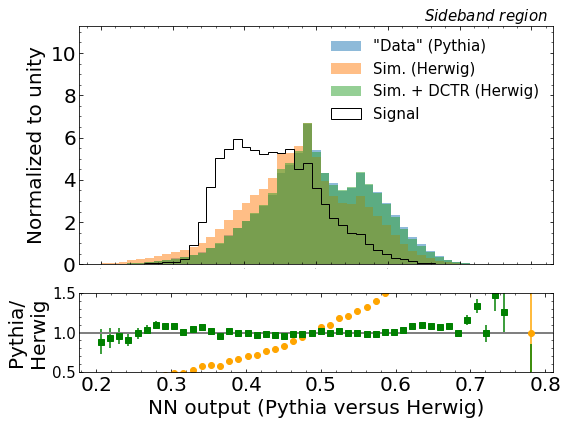

In [138]:
make_plot_weighted(dcpreds_pythia,dcpreds_herwig,dcpreds_signal,weights_test[Y_test==0],np.linspace(0.2,0.8,50),"NN output (Pythia versus Herwig)","nnpythiavherwig_dctr",1.7,False,True,myloc="upper right",dosignal=True)

In [142]:
from random import shuffle

#This one is with Herwig instead of Pythia as the MC.

Nforsig = 5 #was 5
Ntoys = 10 #was 10
Nepochs = 3 #was 5

dhaucs = []
dhmaxsigs = []
dhfpr50s = []
dhsic50s = []
dhmuvals = []

dheaucs = []
dhemaxsigs = []
dhefpr50s = []
dhesic50s = []

for k in range(6,12): #was 2, 12
    #Randomly divide the background in half.  Half is used for testing and half is used for training.  Of the half
    #used for training, divide it in half again - half will have some signal added and half will not.
    #Randomly take a fraction 1/2^k of the signal to add to one part of the background.
    
    indx = np.array(range(len(x_SR_data)))
    shuffle(indx)
    testindx = indx[int(0.5*len(indx)):-1]
    
    indx_signal = np.array(range(len(x_SR_signal)))
    shuffle(indx_signal)
    testindx_signal = indx_signal[int(0.5*len(indx_signal)):-1]  
    
    mu = 1./2**k
    sig_number = int(mu*len(indx)*0.25)
    
    aucs_vec = []
    mymaxsic_vec = []
    myfpr50_vec = []
    mysic50_vec = []
    
    for outerloop in range(Nforsig):
    
        K.clear_session()
        t0 = time.time()
        models = {}
        for itoy in range(Ntoys):
            indx2 = indx[0:int(0.5*len(indx))]
            shuffle(indx2)
            fakeMCindx = indx2[0:int(0.5*len(indx2))]
            fakeDataindx = indx2[int(0.5*len(indx2)):-1]
            injectedindx_signal = indx_signal[0:sig_number]
            
            json_file = open('dctr_model.json', 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            loaded_model = model_from_json(loaded_model_json)
            # load weights into new model
            loaded_model.load_weights("dctr_model.h5")
            
            W_MC = loaded_model.predict(x_SR_MC[fakeMCindx])
            W_MC = W_MC / (1.-W_MC)
            
            X = np.concatenate([x_SR_signal[injectedindx_signal],x_SR_MC[fakeMCindx],x_SR_data[fakeDataindx]])
            Y = np.concatenate([np.ones(len(x_SR_signal[injectedindx_signal])),np.zeros(len(x_SR_MC[fakeMCindx])),np.ones(len(x_SR_data[fakeDataindx]))])
            W = np.concatenate([np.ones(len(x_SR_signal[injectedindx_signal])),W_MC[:,0],np.ones(len(x_SR_data[fakeDataindx]))])
            
            models[itoy] = Sequential()
            models[itoy].add(Dense(64, input_dim=4, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(64, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(64, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(64, activation='relu'))
            models[itoy].add(Dropout(0.1))
            models[itoy].add(Dense(1, activation='sigmoid'))
            models[itoy].compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            models[itoy].fit(X,Y,sample_weight = W,epochs=Nepochs, batch_size=200)
            pass

        Xpure = np.concatenate([x_SR_data[testindx],x_SR_signal[testindx_signal]])
        Ypure = np.concatenate([np.zeros(len(x_SR_data[testindx])),np.ones(len(x_SR_signal[testindx_signal]))])

        mypreds = []
        for itoy in range(Ntoys):
            print(itoy)
            mypreds+=[models[itoy].predict(Xpure)[:,0]]
            pass  
        mypreds = np.array(mypreds)
        preds = [stats.trim_mean(mypreds.T[i], 0.2) for i in range(len(mypreds.T))] #truncated mean    
 
        fpr, tpr, _ = roc_curve(Ypure, preds)
        sic = tpr/(0.0001+fpr)**0.5
        myauc = auc(fpr,tpr)
        mymaxsic = max(sic)
        myfpr50 = fpr[np.where(tpr>0.5)[0][0]]
        mysic50 = sic[np.where(tpr>0.5)[0][0]]
        
        aucs_vec += [myauc]
        mymaxsic_vec += [mymaxsic]
        myfpr50_vec += [myfpr50]
        mysic50_vec += [mysic50]
        t1 = time.time()
        print("    check time:",t1-t0,mu,outerloop,len(Xpure))
        pass
    
    dhmuvals+=[mu]    
    dhaucs+=[np.mean(aucs_vec)]
    dhmaxsigs+=[np.mean(mymaxsic_vec)]
    dhfpr50s = [np.mean(myfpr50_vec)]
    dhsic50s = [np.mean(mysic50_vec)]

    dheaucs+=[np.std(aucs_vec)]
    dhemaxsigs+=[np.std(mymaxsic_vec)]
    dhefpr50s = [np.std(myfpr50_vec)]
    dhesic50s = [np.std(mysic50_vec)]
    
    f = open('herwig_withdctr.txt','a+')
    f.write(str(mu)+" "+str(np.mean(aucs_vec))+" "+str(np.mean(mymaxsic_vec))+" "+str(np.mean(myfpr50_vec))+" "+str(np.mean(mysic50_vec))+ " "+str(np.std(aucs_vec))+" "+str(np.std(mymaxsic_vec))+" "+str(np.std(myfpr50_vec))+" "+str(np.std(mysic50_vec))+"\n")
    f.close()
    
    print(mu,np.mean(aucs_vec),np.mean(mymaxsic_vec),sig_number)
    pass

Epoch 1/3
76929/76929 [==============================] - 3s 44us/step - loss: 0.6798 - acc: 0.5010
Epoch 2/3
76929/76929 [==============================] - 2s 29us/step - loss: 0.6796 - acc: 0.5013
Epoch 3/3
76929/76929 [==============================] - 2s 29us/step - loss: 0.6796 - acc: 0.5007
Epoch 1/3
76929/76929 [==============================] - 4s 49us/step - loss: 0.6785 - acc: 0.5061
Epoch 2/3
76929/76929 [==============================] - 2s 29us/step - loss: 0.6782 - acc: 0.5036
Epoch 3/3
76929/76929 [==============================] - 2s 29us/step - loss: 0.6782 - acc: 0.5028
Epoch 1/3
76929/76929 [==============================] - 4s 53us/step - loss: 0.6800 - acc: 0.5020
Epoch 2/3
76929/76929 [==============================] - 2s 29us/step - loss: 0.6798 - acc: 0.5021
Epoch 3/3
76929/76929 [==============================] - 2s 29us/step - loss: 0.6797 - acc: 0.5005
Epoch 1/3
76929/76929 [==============================] - 4s 57us/step - loss: 0.6786 - acc: 0.5029
Epoch 2/3


76929/76929 [==============================] - 6s 74us/step - loss: 0.6794 - acc: 0.5016
Epoch 2/3
76929/76929 [==============================] - 2s 31us/step - loss: 0.6792 - acc: 0.5018
Epoch 3/3
76929/76929 [==============================] - 2s 31us/step - loss: 0.6791 - acc: 0.5017
Epoch 1/3
76929/76929 [==============================] - 6s 79us/step - loss: 0.6793 - acc: 0.5021
Epoch 2/3
76929/76929 [==============================] - 2s 31us/step - loss: 0.6792 - acc: 0.5035
Epoch 3/3
76929/76929 [==============================] - 2s 32us/step - loss: 0.6792 - acc: 0.5021
Epoch 1/3
76929/76929 [==============================] - 7s 88us/step - loss: 0.6801 - acc: 0.5031
Epoch 2/3
76929/76929 [==============================] - 2s 31us/step - loss: 0.6799 - acc: 0.5019
Epoch 3/3
76929/76929 [==============================] - 2s 31us/step - loss: 0.6799 - acc: 0.5027
0
1
2
3
4
5
6
7
8
9
    check time: 201.8042869567871 0.015625 2 117216
Epoch 1/3
76929/76929 [========================

76631/76631 [==============================] - 2s 31us/step - loss: 0.6795 - acc: 0.5017
Epoch 1/3
76631/76631 [==============================] - 5s 62us/step - loss: 0.6799 - acc: 0.5080
Epoch 2/3
76631/76631 [==============================] - 2s 30us/step - loss: 0.6797 - acc: 0.5073
Epoch 3/3
76631/76631 [==============================] - 2s 30us/step - loss: 0.6796 - acc: 0.5098
Epoch 1/3
76631/76631 [==============================] - 5s 66us/step - loss: 0.6802 - acc: 0.5008
Epoch 2/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6801 - acc: 0.4995
Epoch 3/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6799 - acc: 0.5004
Epoch 1/3
76631/76631 [==============================] - 5s 71us/step - loss: 0.6794 - acc: 0.5072
Epoch 2/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6793 - acc: 0.5086
Epoch 3/3
76631/76631 [==============================] - 2s 31us/step - loss: 0.6793 - acc: 0.5078
Epoch 1/3
76631/7663

76631/76631 [==============================] - 2s 29us/step - loss: 0.6797 - acc: 0.5068
Epoch 3/3
76631/76631 [==============================] - 2s 29us/step - loss: 0.6797 - acc: 0.5073
Epoch 1/3
76631/76631 [==============================] - 3s 44us/step - loss: 0.6798 - acc: 0.5027
Epoch 2/3
76631/76631 [==============================] - 2s 29us/step - loss: 0.6797 - acc: 0.5000
Epoch 3/3
76631/76631 [==============================] - 2s 29us/step - loss: 0.6796 - acc: 0.4999
Epoch 1/3
76631/76631 [==============================] - 4s 56us/step - loss: 0.6800 - acc: 0.5069
Epoch 2/3
76631/76631 [==============================] - 2s 30us/step - loss: 0.6798 - acc: 0.5047
Epoch 3/3
76631/76631 [==============================] - 2s 29us/step - loss: 0.6798 - acc: 0.5013
Epoch 1/3
76631/76631 [==============================] - 4s 57us/step - loss: 0.6793 - acc: 0.5041
Epoch 2/3
76631/76631 [==============================] - 2s 30us/step - loss: 0.6793 - acc: 0.5027
Epoch 3/3
76631/7663

76482/76482 [==============================] - 6s 75us/step - loss: 0.6795 - acc: 0.5073
Epoch 2/3
76482/76482 [==============================] - 2s 31us/step - loss: 0.6794 - acc: 0.5071
Epoch 3/3
76482/76482 [==============================] - 2s 31us/step - loss: 0.6792 - acc: 0.5095
Epoch 1/3
76482/76482 [==============================] - 6s 77us/step - loss: 0.6800 - acc: 0.5012
Epoch 2/3
76482/76482 [==============================] - 2s 31us/step - loss: 0.6797 - acc: 0.5074
Epoch 3/3
76482/76482 [==============================] - 2s 31us/step - loss: 0.6797 - acc: 0.5071
Epoch 1/3
76482/76482 [==============================] - 7s 87us/step - loss: 0.6797 - acc: 0.5055
Epoch 2/3
76482/76482 [==============================] - 3s 34us/step - loss: 0.6795 - acc: 0.5039
Epoch 3/3
76482/76482 [==============================] - 3s 34us/step - loss: 0.6796 - acc: 0.5011
0
1
2
3
4
5
6
7
8
9
    check time: 201.46616435050964 0.00390625 0 117216
Epoch 1/3
76482/76482 [=====================

76482/76482 [==============================] - 2s 29us/step - loss: 0.6801 - acc: 0.4999
Epoch 1/3
76482/76482 [==============================] - 5s 68us/step - loss: 0.6799 - acc: 0.5049
Epoch 2/3
76482/76482 [==============================] - 2s 30us/step - loss: 0.6798 - acc: 0.5016
Epoch 3/3
76482/76482 [==============================] - 2s 31us/step - loss: 0.6797 - acc: 0.5035
Epoch 1/3
76482/76482 [==============================] - 5s 66us/step - loss: 0.6801 - acc: 0.5018
Epoch 2/3
76482/76482 [==============================] - 2s 30us/step - loss: 0.6798 - acc: 0.5065
Epoch 3/3
76482/76482 [==============================] - 2s 31us/step - loss: 0.6798 - acc: 0.5046
Epoch 1/3
76482/76482 [==============================] - 5s 71us/step - loss: 0.6797 - acc: 0.5057
Epoch 2/3
76482/76482 [==============================] - 2s 31us/step - loss: 0.6795 - acc: 0.5057
Epoch 3/3
76482/76482 [==============================] - 2s 30us/step - loss: 0.6795 - acc: 0.5053
Epoch 1/3
76482/7648

76407/76407 [==============================] - 2s 29us/step - loss: 0.6796 - acc: 0.5086
Epoch 3/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6795 - acc: 0.5065
Epoch 1/3
76407/76407 [==============================] - 4s 46us/step - loss: 0.6799 - acc: 0.5039
Epoch 2/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6799 - acc: 0.5012
Epoch 3/3
76407/76407 [==============================] - 2s 32us/step - loss: 0.6797 - acc: 0.5055
Epoch 1/3
76407/76407 [==============================] - 4s 47us/step - loss: 0.6798 - acc: 0.5020
Epoch 2/3
76407/76407 [==============================] - 2s 29us/step - loss: 0.6797 - acc: 0.5016
Epoch 3/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6796 - acc: 0.5032
Epoch 1/3
76407/76407 [==============================] - 4s 50us/step - loss: 0.6794 - acc: 0.5011
Epoch 2/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6792 - acc: 0.5016
Epoch 3/3
76407/7640

76407/76407 [==============================] - 2s 31us/step - loss: 0.6797 - acc: 0.5005
Epoch 3/3
76407/76407 [==============================] - 2s 30us/step - loss: 0.6796 - acc: 0.5027
Epoch 1/3
76407/76407 [==============================] - 6s 79us/step - loss: 0.6799 - acc: 0.5044
Epoch 2/3
76407/76407 [==============================] - 2s 31us/step - loss: 0.6797 - acc: 0.5006
Epoch 3/3
76407/76407 [==============================] - 2s 31us/step - loss: 0.6796 - acc: 0.5039
Epoch 1/3
76407/76407 [==============================] - 6s 83us/step - loss: 0.6793 - acc: 0.5046
Epoch 2/3
76407/76407 [==============================] - 2s 32us/step - loss: 0.6790 - acc: 0.5052
Epoch 3/3
76407/76407 [==============================] - 2s 32us/step - loss: 0.6789 - acc: 0.5090
0
1
2
3
4
5
6
7
8
9
    check time: 202.04882311820984 0.001953125 3 117216
Epoch 1/3
76407/76407 [==============================] - 3s 46us/step - loss: 0.6796 - acc: 0.5011
Epoch 2/3
76407/76407 [====================

Epoch 1/3
76370/76370 [==============================] - 5s 63us/step - loss: 0.6798 - acc: 0.5082
Epoch 2/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6797 - acc: 0.5095
Epoch 3/3
76370/76370 [==============================] - 2s 31us/step - loss: 0.6796 - acc: 0.5130
Epoch 1/3
76370/76370 [==============================] - 5s 67us/step - loss: 0.6799 - acc: 0.5021
Epoch 2/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6797 - acc: 0.5082
Epoch 3/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6797 - acc: 0.5078
Epoch 1/3
76370/76370 [==============================] - 6s 73us/step - loss: 0.6791 - acc: 0.5103
Epoch 2/3
76370/76370 [==============================] - 2s 31us/step - loss: 0.6788 - acc: 0.5175
Epoch 3/3
76370/76370 [==============================] - 2s 31us/step - loss: 0.6788 - acc: 0.5171
Epoch 1/3
76370/76370 [==============================] - 6s 75us/step - loss: 0.6798 - acc: 0.5079
Epoch 2/3


76370/76370 [==============================] - 2s 29us/step - loss: 0.6793 - acc: 0.5128
Epoch 1/3
76370/76370 [==============================] - 4s 49us/step - loss: 0.6797 - acc: 0.5083
Epoch 2/3
76370/76370 [==============================] - 2s 29us/step - loss: 0.6794 - acc: 0.5143
Epoch 3/3
76370/76370 [==============================] - 2s 29us/step - loss: 0.6795 - acc: 0.5137
Epoch 1/3
76370/76370 [==============================] - 4s 52us/step - loss: 0.6802 - acc: 0.5027
Epoch 2/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6800 - acc: 0.5066
Epoch 3/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6800 - acc: 0.5076
Epoch 1/3
76370/76370 [==============================] - 4s 56us/step - loss: 0.6799 - acc: 0.5100
Epoch 2/3
76370/76370 [==============================] - 2s 30us/step - loss: 0.6797 - acc: 0.5127
Epoch 3/3
76370/76370 [==============================] - 2s 31us/step - loss: 0.6797 - acc: 0.5121
Epoch 1/3
76370/7637

76351/76351 [==============================] - 2s 30us/step - loss: 0.6792 - acc: 0.5059
Epoch 3/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6791 - acc: 0.5062
Epoch 1/3
76351/76351 [==============================] - 6s 78us/step - loss: 0.6790 - acc: 0.5056
Epoch 2/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6789 - acc: 0.5087
Epoch 3/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6787 - acc: 0.5104
Epoch 1/3
76351/76351 [==============================] - 6s 83us/step - loss: 0.6797 - acc: 0.5065
Epoch 2/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6795 - acc: 0.5051
Epoch 3/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6794 - acc: 0.5112
0
1
2
3
4
5
6
7
8
9
    check time: 210.71826767921448 0.00048828125 1 117216
Epoch 1/3
76351/76351 [==============================] - 3s 45us/step - loss: 0.6798 - acc: 0.5057
Epoch 2/3
76351/76351 [==================

76351/76351 [==============================] - 5s 61us/step - loss: 0.6787 - acc: 0.5112
Epoch 2/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6785 - acc: 0.5076
Epoch 3/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6784 - acc: 0.5114
Epoch 1/3
76351/76351 [==============================] - 5s 65us/step - loss: 0.6793 - acc: 0.5094
Epoch 2/3
76351/76351 [==============================] - 2s 30us/step - loss: 0.6791 - acc: 0.5083
Epoch 3/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6791 - acc: 0.5090
Epoch 1/3
76351/76351 [==============================] - 5s 70us/step - loss: 0.6786 - acc: 0.5070
Epoch 2/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6784 - acc: 0.5141
Epoch 3/3
76351/76351 [==============================] - 2s 31us/step - loss: 0.6783 - acc: 0.5179
Epoch 1/3
76351/76351 [==============================] - 6s 75us/step - loss: 0.6790 - acc: 0.5060
Epoch 2/3
76351/7635

In [98]:
#read in from file

myfile = open("herwig_nodctr.txt")

haucs = []
hmaxsigs = []
hfpr50s = []
hsic50s = []
hmuvals = []

heaucs = []
hemaxsigs = []
hefpr50s = []
hesic50s = []

for line in myfile:
    hmuvals+=[float(line.split()[0])]
    haucs+=[float(line.split()[1])]
    hmaxsigs+=[float(line.split()[2])]
    hfpr50s+=[float(line.split()[3])]
    hsic50s+=[float(line.split()[4])]
    
    heaucs+=[float(line.split()[5])]
    hemaxsigs+=[float(line.split()[6])]
    hefpr50s+=[float(line.split()[7])]
    hesic50s+=[float(line.split()[8])]    
    pass

haucs = np.array(haucs)
hmaxsigs = np.array(hmaxsigs)
hfpr50s = np.array(hfpr50s)
hsic50s = np.array(hsic50s)
hmuvals = np.array(hmuvals)

heaucs = np.array(heaucs)
hemaxsigs = np.array(hemaxsigs)
hefpr50s = np.array(hefpr50s)
hesic50s = np.array(hesic50s)

In [143]:
#read in from file

myfile = open("herwig_withdctr.txt")

dhaucs = []
dhmaxsigs = []
dhfpr50s = []
dhsic50s = []
dhmuvals = []

dheaucs = []
dhemaxsigs = []
dhefpr50s = []
dhesic50s = []

for line in myfile:
    dhmuvals+=[float(line.split()[0])]
    dhaucs+=[float(line.split()[1])]
    dhmaxsigs+=[float(line.split()[2])]
    dhfpr50s+=[float(line.split()[3])]
    dhsic50s+=[float(line.split()[4])]
    
    dheaucs+=[float(line.split()[5])]
    dhemaxsigs+=[float(line.split()[6])]
    dhefpr50s+=[float(line.split()[7])]
    dhesic50s+=[float(line.split()[8])]    
    pass

dhaucs = np.array(dhaucs)
dhmaxsigs = np.array(dhmaxsigs)
dhfpr50s = np.array(dhfpr50s)
dhsic50s = np.array(dhsic50s)
dhmuvals = np.array(dhmuvals)

dheaucs = np.array(dheaucs)
dhemaxsigs = np.array(dhemaxsigs)
dhefpr50s = np.array(dhefpr50s)
dhesic50s = np.array(dhesic50s)

In [89]:
#read in from file

myfile = open("pythia_nodctr.txt")

aucs = []
maxsigs = []
fpr50s = []
sic50s = []
muvals = []

eaucs = []
emaxsigs = []
efpr50s = []
esic50s = []

for line in myfile:
    muvals+=[float(line.split()[0])]
    aucs+=[float(line.split()[1])]
    maxsigs+=[float(line.split()[2])]
    fpr50s+=[float(line.split()[3])]
    sic50s+=[float(line.split()[4])]
    
    eaucs+=[float(line.split()[5])]
    emaxsigs+=[float(line.split()[6])]
    efpr50s+=[float(line.split()[7])]
    esic50s+=[float(line.split()[8])]    
    pass

aucs = np.array(aucs)
maxsigs = np.array(maxsigs)
fpr50s = np.array(fpr50s)
sic50s = np.array(sic50s)
muvals = np.array(muvals)

eaucs = np.array(eaucs)
emaxsigs = np.array(emaxsigs)
efpr50s = np.array(efpr50s)
esic50s = np.array(esic50s)

In [87]:
for i in range(len(aucs)):
    print(i,aucs[i],maxsigs[i],muvals[i],muvals[i])

0 0.9414148391253118 9.412682033084355 0.25 0.25
1 0.9357091381120599 6.958033083202307 0.125 0.125
2 0.9257339603451943 4.50073126371379 0.0625 0.0625
3 0.9151079036231975 3.420380397505073 0.03125 0.03125
4 0.9003646607053684 2.354358899669463 0.015625 0.015625
5 0.8921738787387081 2.3628811334510966 0.0078125 0.0078125
6 0.8735657689569706 2.1090513541013562 0.00390625 0.00390625
7 0.5096178457180434 1.2312236142040447 0.001953125 0.001953125
8 0.7151853117989276 1.3641115575866287 0.0009765625 0.0009765625
9 0.45954432303735204 1.1994065375470813 0.00048828125 0.00048828125


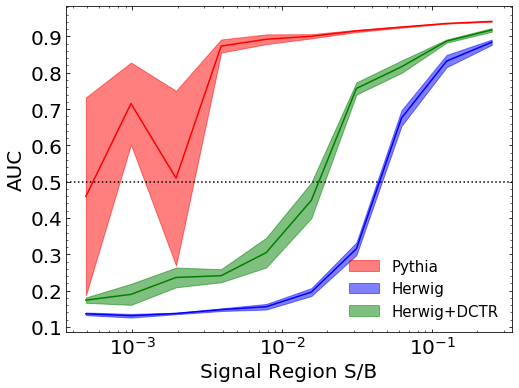

In [144]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.plot(muvals,aucs,color='red')
plt.plot(muvals,haucs,color='blue')
plt.plot(muvals,dhaucs,color='green')
plt.fill_between(muvals, aucs-eaucs, aucs+eaucs,alpha=0.5,color='red',label="Pythia")
plt.fill_between(muvals, haucs-heaucs, haucs+heaucs,alpha=0.5,color='blue',label="Herwig")
plt.fill_between(muvals, dhaucs-dheaucs, dhaucs+dheaucs,alpha=0.5,color='green',label="Herwig+DCTR")
plt.xscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Signal Region S/B",fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.axhline(y=0.5,color="black",ls=":")
plt.legend(frameon=False,fontsize=15,loc="lower right")
plt.savefig("plots/nodctrauc.pdf")

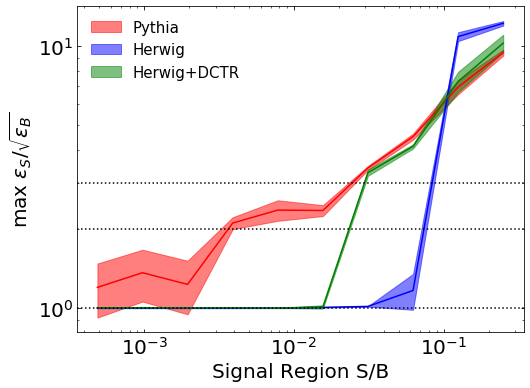

In [145]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.plot(muvals,maxsigs,color='red')
plt.plot(muvals,hmaxsigs,color='blue')
plt.plot(muvals,dhmaxsigs,color='green')
plt.fill_between(muvals, maxsigs-emaxsigs, maxsigs+emaxsigs,alpha=0.5,color='red',label="Pythia")
plt.fill_between(muvals, hmaxsigs-hemaxsigs, hmaxsigs+hemaxsigs,alpha=0.5,color='blue',label="Herwig")
plt.fill_between(muvals, dhmaxsigs-dhemaxsigs, dhmaxsigs+dhemaxsigs,alpha=0.5,color='green',label="Herwig+DCTR")
plt.xscale("log")
plt.yscale("log")
plt.axhline(y=1,color="black",ls=":")
plt.axhline(y=2,color="black",ls=":")
plt.axhline(y=3,color="black",ls=":")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Signal Region S/B",fontsize=20)
plt.ylabel(r"max $\epsilon_S/\sqrt{\epsilon_B}$",fontsize=20)
plt.legend(frameon=False,fontsize=15)
plt.savefig("plots/nodctrmaxsic.pdf")

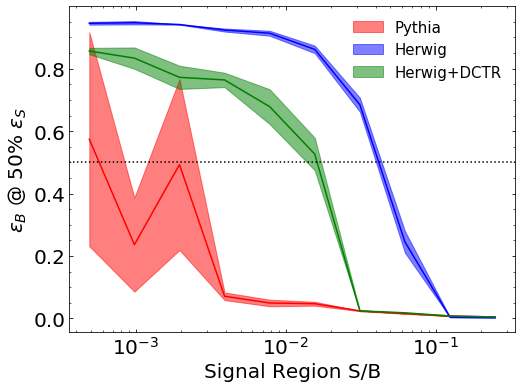

In [146]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.plot(muvals,fpr50s,color='red')
plt.plot(muvals,hfpr50s,color='blue')
plt.plot(muvals,dhfpr50s,color='green')
plt.fill_between(muvals, fpr50s-efpr50s, fpr50s+efpr50s,alpha=0.5,color='red',label="Pythia")
plt.fill_between(muvals, hfpr50s-hefpr50s, hfpr50s+hefpr50s,alpha=0.5,color='blue',label="Herwig")
plt.fill_between(muvals, dhfpr50s-dhefpr50s, dhfpr50s+dhefpr50s,alpha=0.5,color='green',label="Herwig+DCTR")
plt.xscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Signal Region S/B",fontsize=20)
plt.ylabel(r"$\epsilon_B$ @ 50% $\epsilon_S$",fontsize=20)
plt.axhline(y=0.5,color="black",ls=":")
plt.legend(frameon=False,fontsize=15,loc="upper right")
plt.savefig("plots/nodctr50fpr.pdf")

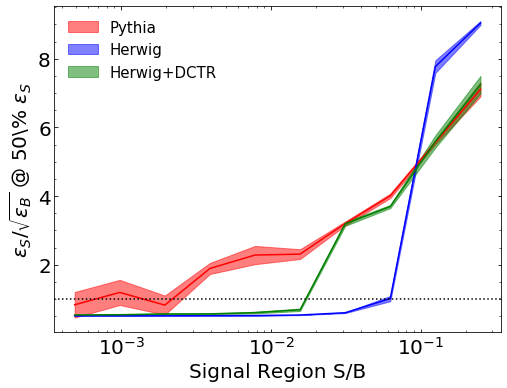

In [147]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.plot(muvals,sic50s,color='red')
plt.plot(muvals,hsic50s,color='blue')
plt.plot(muvals,dhsic50s,color='green')
plt.fill_between(muvals, sic50s-esic50s, sic50s+esic50s,alpha=0.5,color='red',label="Pythia")
plt.fill_between(muvals, hsic50s-hesic50s, hsic50s+hesic50s,alpha=0.5,color='blue',label="Herwig")
plt.fill_between(muvals, dhsic50s-dhesic50s, dhsic50s+dhesic50s,alpha=0.5,color='green',label="Herwig+DCTR")
plt.xscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Signal Region S/B",fontsize=20)
plt.ylabel(r"$\epsilon_S/\sqrt{\epsilon_B}$ @ 50\% $\epsilon_S$",fontsize=20)
plt.axhline(y=1,color="black",ls=":")
plt.legend(frameon=False,fontsize=15)
plt.savefig("plots/nodctr50sic.pdf")

In [79]:
#Now, time to start dctring.

In [10]:
model = Sequential()
model.add(Dense(10, input_dim=14, activation='elu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='elu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
SR_low  = 3250
SR_high = 3750

In [12]:
labels0 = np.zeros(len(pythia_np[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]))
labels1 = np.ones(len(signal_np[(mjj_signal > SR_low)*(mjj_signal < SR_high)]))
X = np.concatenate((pythia_np[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)], signal_np[(mjj_signal > SR_low)*(mjj_signal < SR_high)]))
Y = np.concatenate((labels0, labels1))
X = X/1000.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8)

In [13]:
model.fit(X_train, Y_train, epochs=5, batch_size=100)

Epoch 1/5
46887/46887 [==============================] - 4s 83us/step - loss: 0.6062 - acc: 0.6641
Epoch 2/5
46887/46887 [==============================] - 2s 44us/step - loss: 0.4751 - acc: 0.7811
Epoch 3/5
46887/46887 [==============================] - 2s 44us/step - loss: 0.4287 - acc: 0.8134
Epoch 4/5
46887/46887 [==============================] - 2s 45us/step - loss: 0.4038 - acc: 0.8285
Epoch 5/5
46887/46887 [==============================] - 2s 46us/step - loss: 0.3893 - acc: 0.8347


In [14]:
preds = model.predict(X_test)

In [15]:
fpr, tpr, _ = roc_curve(Y_test, preds)
from sklearn import metrics
metrics.auc(fpr,tpr)

0.9113138863289277

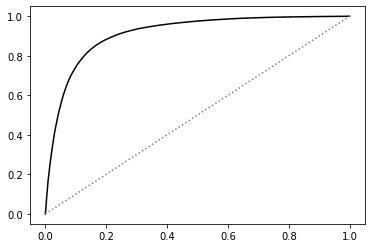

In [16]:
plt.plot(fpr, tpr, color='black')
plt.plot([0,1],[0,1],color="gray",ls=":")

In [17]:
for mu in [1.,0.1,0.01]:
    X0 = pythia_np[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
    X1 = signal_np[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
    Xb = np.concatenate((X0[0:int(0.5*len(X0))],X0[int(0.5*len(X0)):-1],X1[0:int(mu*len(X1))]))
    Yb = np.concatenate((labels0[0:int(0.5*len(labels0))],labels0[int(0.5*len(labels0)):-1],labels1[0:int(mu*len(labels1))]))
    Xb = Xb/1000.
    X_trainb, X_testb, Y_trainb, Y_testb = train_test_split(Xb, Yb, test_size=0.8)
    model = Sequential()
    model.add(Dense(10, input_dim=14, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_trainb, Y_trainb, epochs=10, batch_size=100)
    preds = model.predict(X_test)
    fpr, tpr, _ = roc_curve(Y_test, preds)
    print(mu,metrics.auc(fpr,tpr),len(labels1[0:int(mu*len(labels1))])/len(labels0[int(0.5*len(labels0)):-1]))

Epoch 1/10
46887/46887 [==============================] - 2s 52us/step - loss: 0.6094 - acc: 0.6550
Epoch 2/10
46887/46887 [==============================] - 2s 45us/step - loss: 0.5094 - acc: 0.7529
Epoch 3/10
46887/46887 [==============================] - 2s 44us/step - loss: 0.4493 - acc: 0.8012
Epoch 4/10
46887/46887 [==============================] - 2s 43us/step - loss: 0.4182 - acc: 0.8226
Epoch 5/10
46887/46887 [==============================] - 2s 44us/step - loss: 0.4045 - acc: 0.8300
Epoch 6/10
46887/46887 [==============================] - 2s 44us/step - loss: 0.3977 - acc: 0.8338
Epoch 7/10
46887/46887 [==============================] - 2s 45us/step - loss: 0.3916 - acc: 0.8363
Epoch 8/10
46887/46887 [==============================] - 2s 46us/step - loss: 0.3873 - acc: 0.8375
Epoch 9/10
46887/46887 [==============================] - 2s 47us/step - loss: 0.3830 - acc: 0.8383
Epoch 10/10
46887/46887 [==============================] - 2s 46us/step - loss: 0.3798 - acc: 0.8387

In [18]:
m_background_data = mjj_pythia/1000.
m_background_MC = mjj_herwig/1000.
m_signal = mjj_signal/1000.

x_background_data = maxmass_pythia/1000.
x_background_MC = maxmass_herwig/1000.
x_signal = maxmass_signal/1000.

Text(0, 0.5, 'Normalized to unity')

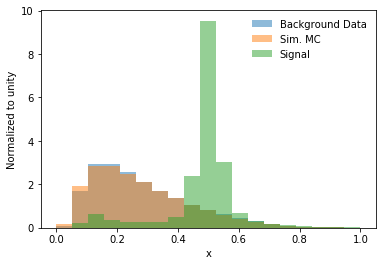

In [19]:
_,_,_=plt.hist(x_background_data,bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Background Data")
_,_,_=plt.hist(x_background_MC,bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Sim. MC")
_,_,_=plt.hist(x_signal,bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Signal")
plt.legend(frameon=False)
plt.xlabel("x")
plt.ylabel("Normalized to unity")

Text(0, 0.5, 'x')

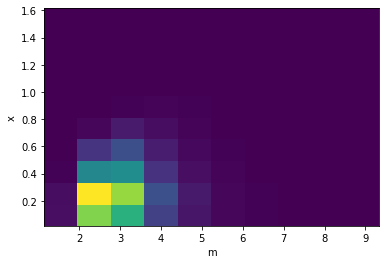

In [20]:
plt.hist2d(m_background_data,x_background_data)
plt.xlabel("m")
plt.ylabel("x")

In [21]:
SR_low = 3250/1000.
SR_high = 3750/1000.

In [22]:
#Prepare the DCTR training, excluding the SR.

Data_labels = np.ones(len(m_background_data))
Sim_labels = np.zeros(len(m_background_MC))

X_background_data = np.reshape(np.concatenate([m_background_data,x_background_data]),[len(m_background_data),2],order='F')
X_signal = np.reshape(np.concatenate([m_signal,x_signal]),[len(m_signal),2],order='F')
X_background_sim = np.reshape(np.concatenate([m_background_MC,x_background_MC]),[len(m_background_MC),2],order='F')

X = np.concatenate([X_background_data[(m_background_data < SR_low) + (m_background_data > SR_high)],X_background_sim[(m_background_MC < SR_low) + (m_background_MC > SR_high)]])
Y = np.concatenate([Data_labels[(m_background_data < SR_low) + (m_background_data > SR_high)],Sim_labels[(m_background_MC < SR_low) + (m_background_MC > SR_high)]])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [23]:
cmodel = Sequential()
cmodel.add(Dense(64, input_dim=2, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(128, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(256, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(32, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(1, activation='sigmoid'))
cmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
cmodel.fit(X_train,Y_train, epochs=5, batch_size=200)

Epoch 1/5
846811/846811 [==============================] - 26s 30us/step - loss: 0.6939 - acc: 0.5030
Epoch 2/5
846811/846811 [==============================] - 25s 30us/step - loss: 0.6930 - acc: 0.5067
Epoch 3/5
846811/846811 [==============================] - 25s 30us/step - loss: 0.6929 - acc: 0.5073
Epoch 4/5
846811/846811 [==============================] - 25s 29us/step - loss: 0.6927 - acc: 0.5096
Epoch 5/5
846811/846811 [==============================] - 25s 30us/step - loss: 0.6926 - acc: 0.5103


In [25]:
weights_test = cmodel.predict(X_test)
weights_test = weights_test / (1.-weights_test)

Text(0, 0.5, 'Normalized to unity')

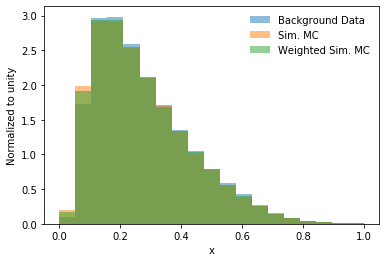

In [26]:
_,_,_=plt.hist(X_test[Y_test==1][:,1],bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Background Data")
_,_,_=plt.hist(X_test[Y_test==0][:,1],bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Sim. MC")
_,_,_=plt.hist(X_test[Y_test==0][:,1],bins=np.linspace(0,1,20),density=True,weights = weights_test[Y_test==0],alpha=0.5,label="Weighted Sim. MC")
plt.legend(frameon=False)
plt.xlabel("x")
plt.ylabel("Normalized to unity")

In [27]:
X_SR = np.concatenate([X_background_data[(m_background_data > SR_low) * (m_background_data < SR_high)],X_background_sim[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])
Y_SR = np.concatenate([Data_labels[(m_background_data > SR_low) * (m_background_data < SR_high)],Sim_labels[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])
X_train_SR, X_test_SR, Y_train_SR, Y_test_SR = train_test_split(X_SR, Y_SR, test_size=0.5)

In [28]:
weights_test_SR = cmodel.predict(X_test_SR)
weights_test_SR = weights_test_SR / (1.-weights_test_SR)

Text(0, 0.5, 'Normalized to unity')

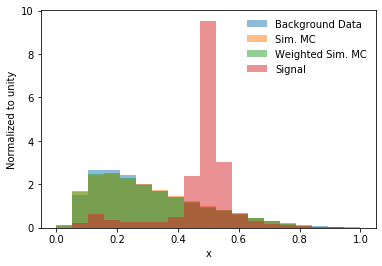

In [29]:
#Now, let's check in the SR.
_,_,_=plt.hist(X_test_SR[Y_test_SR==1][:,1],bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Background Data")
_,_,_=plt.hist(X_test_SR[Y_test_SR==0][:,1],bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Sim. MC")
_,_,_=plt.hist(X_test_SR[Y_test_SR==0][:,1],bins=np.linspace(0,1,20),density=True,weights = weights_test_SR[Y_test_SR==0],alpha=0.5,label="Weighted Sim. MC")
_,_,_=plt.hist(x_signal,bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Signal")
plt.legend(frameon=False)
plt.xlabel("x")
plt.ylabel("Normalized to unity")

Next, let's train a classifier to distinguish the reweighted signal region simulation from the data (with and without signal)

In [30]:
#First, no signal
weights_train_SR = cmodel.predict(X_train_SR)
weights_train_SR = weights_train_SR / (1.-weights_train_SR)
W_train_SR = []
for i in range(len(Y_train_SR)):
    if (Y_train_SR[i]==1):
        W_train_SR += [1.]
    else:
        W_train_SR += [weights_train_SR[i]]
        pass
    pass
W_train_SR=np.array(W_train_SR)

weights_test_SR = cmodel.predict(X_test_SR)
weights_test_SR = weights_test_SR / (1.-weights_test_SR)
W_test_SR = []
for i in range(len(Y_test_SR)):
    if (weights_test_SR[i]==1):
        W_test_SR += [1.]
    else:
        W_test_SR += [weights_test_SR[i]]
        pass
    pass
W_test_SR = np.array(W_test_SR)
W_test_SR = W_test_SR

In [31]:
amodel = Sequential()
amodel.add(Dense(10, input_dim=2, activation='elu'))
amodel.add(Dropout(0.1))
amodel.add(Dense(20, activation='elu'))
amodel.add(Dropout(0.1))
amodel.add(Dense(1, activation='sigmoid'))
amodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
amodel.fit(X_train_SR,Y_train_SR, epochs=5, sample_weight=W_train_SR,batch_size=200)

Epoch 1/5
153188/153188 [==============================] - 4s 27us/step - loss: 0.6986 - acc: 0.5020
Epoch 2/5
153188/153188 [==============================] - 4s 23us/step - loss: 0.6960 - acc: 0.5006
Epoch 3/5
153188/153188 [==============================] - 4s 24us/step - loss: 0.6958 - acc: 0.4991
Epoch 4/5
153188/153188 [==============================] - 4s 24us/step - loss: 0.6956 - acc: 0.5005
Epoch 5/5
153188/153188 [==============================] - 4s 24us/step - loss: 0.6955 - acc: 0.5009


In [33]:
amodel_nodctr = Sequential()
amodel_nodctr.add(Dense(10, input_dim=2, activation='elu'))
amodel_nodctr.add(Dropout(0.1))
amodel_nodctr.add(Dense(20, activation='elu'))
amodel_nodctr.add(Dropout(0.1))
amodel_nodctr.add(Dense(1, activation='sigmoid'))
amodel_nodctr.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
amodel_nodctr.fit(X_train_SR,Y_train_SR, epochs=5,batch_size=200)

Epoch 1/5
153188/153188 [==============================] - 4s 27us/step - loss: 0.7019 - acc: 0.5011
Epoch 2/5
153188/153188 [==============================] - 4s 23us/step - loss: 0.6944 - acc: 0.5001
Epoch 3/5
153188/153188 [==============================] - 4s 23us/step - loss: 0.6938 - acc: 0.5003
Epoch 4/5
153188/153188 [==============================] - 4s 24us/step - loss: 0.6935 - acc: 0.5024
Epoch 5/5
153188/153188 [==============================] - 4s 24us/step - loss: 0.6933 - acc: 0.5022


In [35]:
#Second, with signal
X_SR_wsig = np.concatenate([np.concatenate([X_background_data[(m_background_data > SR_low)*(m_background_data < SR_high)],X_signal]),X_background_sim[(m_background_MC > SR_low)*(m_background_MC < SR_high)]])
Y_SR_wsig = np.concatenate([np.concatenate([Data_labels[(m_background_data > SR_low)*(m_background_data < SR_high)],np.ones(len(X_signal))]),Sim_labels[(m_background_MC > SR_low)*(m_background_MC < SR_high)]])
X_train_SR_wsig, X_test_SR_wsig, Y_train_SR_wsig, Y_test_SR_wsig = train_test_split(X_SR_wsig, Y_SR_wsig, test_size=0.5)

weights_train_SR_withsig = cmodel.predict(X_train_SR_wsig)
weights_train_SR_withsig = weights_train_SR_withsig / (1.-weights_train_SR_withsig)
W_train_SR_withsig = []
for i in range(len(Y_train_SR_wsig)):
    if (weights_train_SR_withsig[i]==1):
        W_train_SR_withsig += [1.]
    else:
        W_train_SR_withsig += [weights_train_SR_withsig[i]]
        pass
    pass
W_train_SR_withsig = np.array(W_train_SR_withsig)
W_train_SR_withsig = W_train_SR_withsig

weights_test_SR_withsig = cmodel.predict(X_test_SR_wsig)
weights_test_SR_withsig = weights_test_SR_withsig / (1.-weights_test_SR_withsig)
W_test_SR_withsig = []
for i in range(len(Y_test_SR_wsig)):
    if (weights_test_SR_withsig[i]==1):
        W_test_SR_withsig += [1.]
    else:
        W_test_SR_withsig += [weights_test_SR_withsig[i]]
        pass
    pass
W_test_SR_withsig = np.array(W_test_SR_withsig)
W_test_SR_withsig = W_test_SR_withsig

In [36]:
amodel_wsig = Sequential()
amodel_wsig.add(Dense(10, input_dim=2, activation='elu'))
amodel_wsig.add(Dropout(0.1))
amodel_wsig.add(Dense(20, activation='elu'))
amodel_wsig.add(Dropout(0.1))
amodel_wsig.add(Dense(1, activation='sigmoid'))
amodel_wsig.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
amodel_wsig.fit(X_train_SR_wsig,Y_train_SR_wsig, epochs=5, sample_weight=W_train_SR_withsig[:,0],batch_size=200)

Epoch 1/5
203187/203187 [==============================] - 6s 28us/step - loss: 0.6533 - acc: 0.6196
Epoch 2/5
203187/203187 [==============================] - 5s 24us/step - loss: 0.6489 - acc: 0.6198
Epoch 3/5
203187/203187 [==============================] - 5s 23us/step - loss: 0.6481 - acc: 0.6201
Epoch 4/5
203187/203187 [==============================] - 5s 23us/step - loss: 0.6474 - acc: 0.6194
Epoch 5/5
203187/203187 [==============================] - 5s 23us/step - loss: 0.6469 - acc: 0.6178


In [38]:
#One more training without weights

In [39]:
#Now, some ROC curves
predicts = amodel.predict(X_test_SR)
roc = roc_curve(Y_test_SR,predicts,sample_weight=W_test_SR)

predicts_nodctr = amodel_nodctr.predict(X_test_SR)
roc_nodctr = roc_curve(Y_test_SR,predicts_nodctr)

predicts_wsig = amodel_wsig.predict(X_test_SR_wsig)
roc_wsig = roc_curve(Y_test_SR_wsig,predicts_wsig,sample_weight=W_test_SR_withsig)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


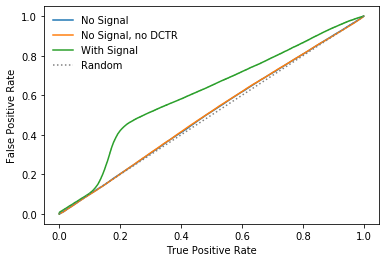

In [40]:
plt.plot(roc[0],roc[1],label="No Signal")
plt.plot(roc_nodctr[0],roc_nodctr[1],label="No Signal, no DCTR")
plt.plot(roc_wsig[0],roc_wsig[1],label="With Signal")
plt.plot([0,1],[0,1],color="gray",ls=":",label="Random")
plt.xlabel("True Positive Rate")
plt.ylabel("False Positive Rate")
plt.legend(frameon=False)

In [41]:
#Now, retry, but make the other dimension bigger - use all features.

In [42]:
np.shape(signal_np[0])

(14,)

In [43]:
signal

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


In [53]:
#x2_background_data = np.concatenate()
#x_background_MC = maxmass_herwig/1000.
#x_signal = maxmass_signal/1000.

In [54]:
x2_signal = np.concatenate((np.reshape(np.array(signal['mj1'])/1000.,(len(signal),1)),np.reshape(np.array(signal['mj2'])/1000.,(len(signal),1)),np.reshape(np.array(signal['tau2j1']/(0.0001+signal['tau1j1'])),(len(signal),1)),np.reshape(np.array(signal['tau2j2']/(0.0001+signal['tau1j2'])),(len(signal),1))),axis=1)
x2_background_data = np.concatenate((np.reshape(np.array(herwig['mj1'])/1000.,(len(herwig),1)),np.reshape(np.array(herwig['mj2'])/1000.,(len(herwig),1)),np.reshape(np.array(herwig['tau2j1']/(0.0001+herwig['tau1j1'])),(len(herwig),1)),np.reshape(np.array(herwig['tau2j2']/(0.0001+herwig['tau1j2'])),(len(herwig),1))),axis=1)
x2_background_MC = np.concatenate((np.reshape(np.array(pythia['mj1'])/1000.,(len(pythia),1)),np.reshape(np.array(pythia['mj2'])/1000.,(len(pythia),1)),np.reshape(np.array(pythia['tau2j1']/(0.0001+pythia['tau1j1'])),(len(pythia),1)),np.reshape(np.array(pythia['tau2j2']/(0.0001+pythia['tau1j2'])),(len(pythia),1))),axis=1)

(array([1.30009604, 4.40942715, 3.58224019, 2.55379267, 1.85609068,
        1.35896494, 1.03219216, 0.78491236, 0.6047701 , 0.46441234,
        0.3565969 , 0.26583197, 0.18299352, 0.11270059, 0.06371604,
        0.03537456, 0.01940754, 0.01018848, 0.00629177]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <a list of 19 Patch objects>)

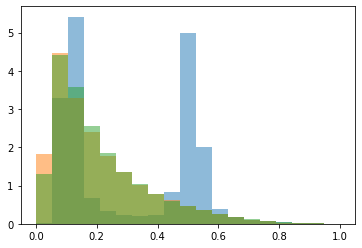

In [58]:
plt.hist(x2_signal[:,0],bins=np.linspace(0,1,20),density=True,alpha=0.5)
plt.hist(x2_background_data[:,0],bins=np.linspace(0,1,20),density=True,alpha=0.5)
plt.hist(x2_background_MC[:,0],bins=np.linspace(0,1,20),density=True,alpha=0.5)

In [59]:
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(np.concatenate((x2_background_data,x2_background_MC)), np.concatenate((np.ones(len(x2_background_data)),np.zeros(len(x2_background_MC)))), test_size=0.5)

In [61]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=256)

Epoch 1/10
999999/999999 [==============================] - 25s 25us/step - loss: 0.6834 - acc: 0.5564
Epoch 2/10
999999/999999 [==============================] - 24s 24us/step - loss: 0.6814 - acc: 0.5618
Epoch 3/10
999999/999999 [==============================] - 24s 24us/step - loss: 0.6809 - acc: 0.5628
Epoch 4/10
999999/999999 [==============================] - 24s 24us/step - loss: 0.6807 - acc: 0.5635
Epoch 5/10
999999/999999 [==============================] - 24s 24us/step - loss: 0.6806 - acc: 0.5633
Epoch 6/10
999999/999999 [==============================] - 24s 24us/step - loss: 0.6804 - acc: 0.5639
Epoch 7/10
999999/999999 [==============================] - 24s 24us/step - loss: 0.6804 - acc: 0.5639
Epoch 8/10
999999/999999 [==============================] - 24s 24us/step - loss: 0.6803 - acc: 0.5646
Epoch 9/10
999999/999999 [==============================] - 24s 24us/step - loss: 0.6803 - acc: 0.5642
Epoch 10/10
999999/999999 [==============================] - 24s 24us/ste

In [62]:
preds = model.predict(X_test) #okay, this can serve as a 1D distribution for testing later.

In [63]:
fpr, tpr, _ = roc_curve(Y_test, preds)
metrics.auc(fpr,tpr)

0.592770842713083

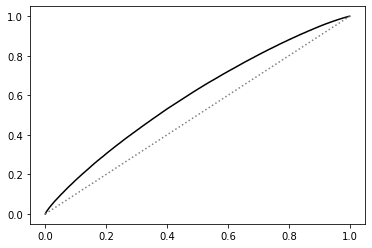

In [64]:
plt.plot(fpr, tpr, color='black')
plt.plot([0,1],[0,1],color="gray",ls=":")

In [130]:
Data_labels = np.ones(len(m_background_data))
Sim_labels = np.zeros(len(m_background_MC))

X_signal = np.concatenate((np.reshape(m_signal,(len(m_signal),1)),np.reshape(np.array(signal['mj1'])/1000.,(len(signal),1)),np.reshape(np.array(signal['mj2'])/1000.,(len(signal),1)),np.reshape(np.array(signal['tau2j1']/(0.0001+signal['tau1j1'])),(len(signal),1)),np.reshape(np.array(signal['tau2j2']/(0.0001+signal['tau1j2'])),(len(signal),1))),axis=1)
X_background_data = np.concatenate((np.reshape(m_background_data,(len(m_background_data),1)),np.reshape(np.array(herwig['mj1'])/1000.,(len(herwig),1)),np.reshape(np.array(herwig['mj2'])/1000.,(len(herwig),1)),np.reshape(np.array(herwig['tau2j1']/(0.0001+herwig['tau1j1'])),(len(herwig),1)),np.reshape(np.array(herwig['tau2j2']/(0.0001+herwig['tau1j2'])),(len(herwig),1))),axis=1)
X_background_sim = np.concatenate((np.reshape(m_background_MC,(len(m_background_MC),1)),np.reshape(np.array(pythia['mj1'])/1000.,(len(pythia),1)),np.reshape(np.array(pythia['mj2'])/1000.,(len(pythia),1)),np.reshape(np.array(pythia['tau2j1']/(0.0001+pythia['tau1j1'])),(len(pythia),1)),np.reshape(np.array(pythia['tau2j2']/(0.0001+pythia['tau1j2'])),(len(pythia),1))),axis=1)

X = np.concatenate([X_background_data[(m_background_data < SR_low) + (m_background_data > SR_high)],X_background_sim[(m_background_MC < SR_low) + (m_background_MC > SR_high)]])
Y = np.concatenate([Data_labels[(m_background_data < SR_low) + (m_background_data > SR_high)],Sim_labels[(m_background_MC < SR_low) + (m_background_MC > SR_high)]])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

In [133]:
'''
cmodel = Sequential()
cmodel.add(Dense(64, input_dim=5, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(128, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(256, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(32, activation='elu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(1, activation='sigmoid'))
cmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
'''

cmodel = Sequential()
cmodel.add(Dense(64, input_dim=5, activation='relu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(64, activation='relu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(64, activation='relu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(64, activation='relu'))
cmodel.add(Dropout(0.1))
cmodel.add(Dense(1, activation='sigmoid'))
cmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
cmodel.fit(X_train,Y_train, epochs=5, batch_size=200,validation_data=(X_test,Y_test))

Train on 846811 samples, validate on 846811 samples
Epoch 1/10
846811/846811 [==============================] - 35s 42us/step - loss: 0.6811 - acc: 0.5627 - val_loss: 0.6796 - val_acc: 0.5658
Epoch 2/10
846811/846811 [==============================] - 35s 41us/step - loss: 0.6810 - acc: 0.5622 - val_loss: 0.6798 - val_acc: 0.5652
Epoch 3/10
846811/846811 [==============================] - 35s 41us/step - loss: 0.6809 - acc: 0.5629 - val_loss: 0.6800 - val_acc: 0.5645
Epoch 4/10
839200/846811 [============================>.] - ETA: 0s - loss: 0.6809 - acc: 0.5629

KeyboardInterrupt: 

In [136]:
weights_test = cmodel.predict(X_test)
weights_test = weights_test / (1.-weights_test)

Text(0, 0.5, 'Normalized to unity')

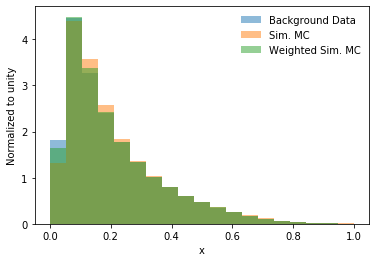

In [142]:
_,_,_=plt.hist(X_test[Y_test==1][:,1],bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Background Data")
_,_,_=plt.hist(X_test[Y_test==0][:,1],bins=np.linspace(0,1,20),density=True,alpha=0.5,label="Sim. MC")
_,_,_=plt.hist(X_test[Y_test==0][:,1],bins=np.linspace(0,1,20),density=True,weights = weights_test[Y_test==0],alpha=0.5,label="Weighted Sim. MC")
plt.legend(frameon=False)
plt.xlabel("x")
plt.ylabel("Normalized to unity")

In [143]:
preds = model.predict(X_test[:,1:])

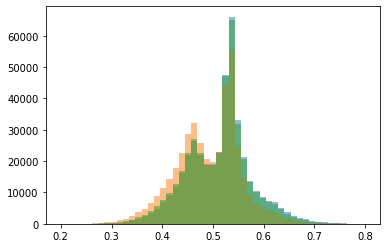

In [144]:
_,_,_=plt.hist(preds[Y_test==1],bins=np.linspace(0.2,0.8,50),alpha=0.5)
_,_,_=plt.hist(preds[Y_test==0],bins=np.linspace(0.2,0.8,50),alpha=0.5)
_,_,_=plt.hist(preds[Y_test==0],bins=np.linspace(0.2,0.8,50),alpha=0.5,weights=weights_test[Y_test==0])

In [72]:
#Now, extrapolate to the SR.

In [73]:
X_inSR = np.concatenate([X_background_data[(m_background_data > SR_low) * (m_background_data < SR_high)],X_background_sim[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])
Y_inSR = np.concatenate([Data_labels[(m_background_data > SR_low) * (m_background_data < SR_high)],Sim_labels[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])

In [74]:
preds_inSR = model.predict(X_inSR[:,1:])

In [138]:
weights_in_SR = cmodel.predict(X_inSR)
weights_in_SR = weights_in_SR / (1.-weights_in_SR)

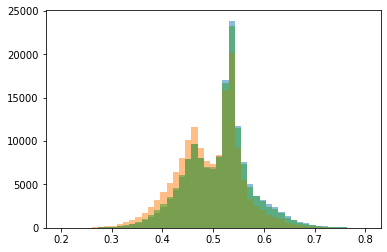

In [139]:
_,_,_=plt.hist(preds_inSR[Y_inSR==1],bins=np.linspace(0.2,0.8,50),alpha=0.5)
_,_,_=plt.hist(preds_inSR[Y_inSR==0],bins=np.linspace(0.2,0.8,50),alpha=0.5)
_,_,_=plt.hist(preds_inSR[Y_inSR==0],bins=np.linspace(0.2,0.8,50),alpha=0.5,weights=weights_in_SR[Y_inSR==0])

In [77]:
#Now, let's make some ROC curves.

In [145]:
#Only apply weights to one of the samples!
W_inSR = np.concatenate([np.ones(len(Data_labels[(m_background_data > SR_low) * (m_background_data < SR_high)])),weights_in_SR[Y_inSR==0][:,0]])

In [146]:
X_train_inSR, X_test_inSR, Y_train_inSR, Y_test_inSR, W_train_inSR, W_test_inSR = train_test_split(X_inSR, Y_inSR, W_inSR, test_size=0.5)

In [147]:
model_noweights = Sequential()
model_noweights.add(Dense(64, input_dim=4, activation='relu'))
model_noweights.add(Dropout(0.1))
model_noweights.add(Dense(64, activation='relu'))
model_noweights.add(Dropout(0.1))
model_noweights.add(Dense(64, activation='relu'))
model_noweights.add(Dropout(0.1))
model_noweights.add(Dense(64, activation='relu'))
model_noweights.add(Dropout(0.1))
model_noweights.add(Dense(1, activation='sigmoid'))
model_noweights.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [148]:
model_noweights.fit(X_train_inSR[:,1:],Y_train_inSR, epochs=5, batch_size=200)

Epoch 1/5
153188/153188 [==============================] - 7s 43us/step - loss: 0.6872 - acc: 0.5440
Epoch 2/5
153188/153188 [==============================] - 5s 31us/step - loss: 0.6841 - acc: 0.5552
Epoch 3/5
153188/153188 [==============================] - 5s 31us/step - loss: 0.6832 - acc: 0.5578
Epoch 4/5
153188/153188 [==============================] - 5s 31us/step - loss: 0.6827 - acc: 0.5592
Epoch 5/5
153188/153188 [==============================] - 5s 31us/step - loss: 0.6824 - acc: 0.5608


In [149]:
model_weights = Sequential()
model_weights.add(Dense(64, input_dim=4, activation='relu'))
model_weights.add(Dropout(0.1))
model_weights.add(Dense(64, activation='relu'))
model_weights.add(Dropout(0.1))
model_weights.add(Dense(64, activation='relu'))
model_weights.add(Dropout(0.1))
model_weights.add(Dense(64, activation='relu'))
model_weights.add(Dropout(0.1))
model_weights.add(Dense(1, activation='sigmoid'))
model_weights.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [150]:
model_weights.fit(X_train_inSR[:,1:],Y_train_inSR, sample_weight = W_train_inSR, epochs=5, batch_size=200)

Epoch 1/5
153188/153188 [==============================] - 7s 44us/step - loss: 0.6882 - acc: 0.5016
Epoch 2/5
153188/153188 [==============================] - 5s 32us/step - loss: 0.6881 - acc: 0.5085
Epoch 3/5
153188/153188 [==============================] - 5s 31us/step - loss: 0.6881 - acc: 0.5134
Epoch 4/5
153188/153188 [==============================] - 5s 32us/step - loss: 0.6881 - acc: 0.5151
Epoch 5/5
153188/153188 [==============================] - 5s 31us/step - loss: 0.6880 - acc: 0.5186


In [151]:
predicts_inSR_noweights = model_noweights.predict(X_test_inSR[:,1:])

In [152]:
fpr_inSR_noweights, tpr_inSR_noweights, _ = roc_curve(Y_test_inSR, predicts_inSR_noweights)
metrics.auc(fpr_inSR_noweights,tpr_inSR_noweights)

0.5876386311539643

In [153]:
predicts_inSR_weights = model_weights.predict(X_test_inSR[:,1:])

In [154]:
fpr_inSR_weights, tpr_inSR_weights, _ = roc_curve(Y_test_inSR, predicts_inSR_weights,sample_weight=W_test_inSR)
metrics.auc(fpr_inSR_weights,tpr_inSR_weights)

0.5124439433121042

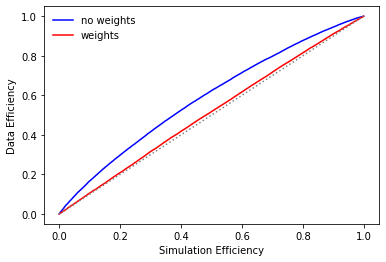

In [155]:
plt.plot(fpr_inSR_noweights, tpr_inSR_noweights, color='blue',label="no weights")
plt.plot(fpr_inSR_weights, tpr_inSR_weights, color='red',label="weights")
plt.plot([0,1],[0,1],color="gray",ls=":")
plt.xlabel("Simulation Efficiency")
plt.ylabel("Data Efficiency")
plt.legend(frameon=False)

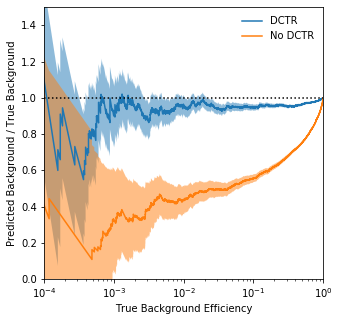

In [161]:
#plt.errorbar(tpr_inSR_weights,fpr_inSR_weights/tpr_inSR_weights,yerr=0,label="DCTR")

dctr = fpr_inSR_weights[tpr_inSR_weights>0]/tpr_inSR_weights[tpr_inSR_weights>0]
nodctr = fpr_inSR_noweights[tpr_inSR_noweights>0]/tpr_inSR_noweights[tpr_inSR_noweights>0]

nevents = len(X_test_inSR[:,1:][Y_test_inSR==0])
edctr = 2**0.5*np.sqrt(nevents*fpr_inSR_weights[tpr_inSR_weights>0])/(nevents*fpr_inSR_weights[tpr_inSR_weights>0])
enodctr = 2**0.5*np.sqrt(nevents*fpr_inSR_noweights[tpr_inSR_noweights>0])/(nevents*fpr_inSR_noweights[tpr_inSR_noweights>0])

plt.figure(figsize=(5,5)) 
plt.plot(tpr_inSR_weights[tpr_inSR_weights>0],dctr,label="DCTR")
plt.fill_between(tpr_inSR_weights[tpr_inSR_weights>0], dctr-edctr, dctr+edctr,alpha=0.5)
plt.plot(tpr_inSR_noweights[tpr_inSR_noweights>0],nodctr,label="No DCTR")
plt.fill_between(tpr_inSR_noweights[tpr_inSR_noweights>0], nodctr-enodctr, nodctr+enodctr,alpha=0.5)
plt.xscale("log")
plt.xlim([1e-4,1])
plt.ylim([0,1.5])
plt.plot([1e-4,1],[1,1],ls=":",color="black")
plt.ylabel("Predicted Background / True Background")
plt.xlabel("True Background Efficiency")
plt.legend(frameon=False)
plt.savefig("BackgroundTest.pdf")

In [90]:
#Next, with signal in both cases.

In [171]:
X_inSR_wsig = np.concatenate([X_signal[(m_signal > SR_low) * (m_signal < SR_high)],X_background_data[(m_background_data > SR_low) * (m_background_data < SR_high)],X_background_sim[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])
Y_inSR_wsig = np.concatenate([np.ones(len(X_signal[(m_signal > SR_low) * (m_signal < SR_high)])),Data_labels[(m_background_data > SR_low) * (m_background_data < SR_high)],Sim_labels[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])
W_inSR_wsig = np.concatenate([np.ones(len(X_signal[(m_signal > SR_low) * (m_signal < SR_high)])),np.ones(len(Data_labels[(m_background_data > SR_low) * (m_background_data < SR_high)])),weights_in_SR[Y_inSR==0][:,0]])

In [172]:
X_train_inSR_wsig, X_test_inSR_wsig, Y_train_inSR_wsig, Y_test_inSR_wsig, W_train_inSR_wsig, W_test_inSR_wsig = train_test_split(X_inSR_wsig, Y_inSR_wsig, W_inSR_wsig, test_size=0.5)

In [173]:
model_noweights_wsig = Sequential()
model_noweights_wsig.add(Dense(64, input_dim=4, activation='relu'))
model_noweights_wsig.add(Dropout(0.1))
model_noweights_wsig.add(Dense(64, activation='relu'))
model_noweights_wsig.add(Dropout(0.1))
model_noweights_wsig.add(Dense(64, activation='relu'))
model_noweights_wsig.add(Dropout(0.1))
model_noweights_wsig.add(Dense(64, activation='relu'))
model_noweights_wsig.add(Dropout(0.1))
model_noweights_wsig.add(Dense(1, activation='sigmoid'))
model_noweights_wsig.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_noweights_wsig.fit(X_train_inSR_wsig[:,1:],Y_train_inSR_wsig, epochs=5, batch_size=200)

Epoch 1/5
194072/194072 [==============================] - 8s 42us/step - loss: 0.6104 - acc: 0.6296
Epoch 2/5
194072/194072 [==============================] - 6s 32us/step - loss: 0.5956 - acc: 0.6386
Epoch 3/5
194072/194072 [==============================] - 6s 32us/step - loss: 0.5905 - acc: 0.6403
Epoch 4/5
194072/194072 [==============================] - 6s 32us/step - loss: 0.5875 - acc: 0.6414
Epoch 5/5
194072/194072 [==============================] - 6s 32us/step - loss: 0.5861 - acc: 0.6421


In [174]:
model_weights_wsig = Sequential()
model_weights_wsig.add(Dense(64, input_dim=4, activation='relu'))
model_weights_wsig.add(Dropout(0.1))
model_weights_wsig.add(Dense(64, activation='relu'))
model_weights_wsig.add(Dropout(0.1))
model_weights_wsig.add(Dense(64, activation='relu'))
model_weights_wsig.add(Dropout(0.1))
model_weights_wsig.add(Dense(64, activation='relu'))
model_weights_wsig.add(Dropout(0.1))
model_weights_wsig.add(Dense(1, activation='sigmoid'))
model_weights_wsig.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_weights_wsig.fit(X_train_inSR_wsig[:,1:],Y_train_inSR_wsig, sample_weight = W_train_inSR_wsig, epochs=5, batch_size=200)

Epoch 1/5
194072/194072 [==============================] - 8s 44us/step - loss: 0.6211 - acc: 0.6093
Epoch 2/5
194072/194072 [==============================] - 6s 32us/step - loss: 0.6028 - acc: 0.6075
Epoch 3/5
194072/194072 [==============================] - 6s 32us/step - loss: 0.5962 - acc: 0.6089
Epoch 4/5
194072/194072 [==============================] - 6s 32us/step - loss: 0.5939 - acc: 0.6123
Epoch 5/5
194072/194072 [==============================] - 6s 32us/step - loss: 0.5922 - acc: 0.6178


In [183]:
X_pure = np.concatenate([X_signal[(m_signal > SR_low) * (m_signal < SR_high)],X_background_data[(m_background_data > SR_low) * (m_background_data < SR_high)]])
Y_pure = np.concatenate([np.ones(len(X_signal[(m_signal > SR_low) * (m_signal < SR_high)])),np.zeros(len(X_background_data[(m_background_data > SR_low) * (m_background_data < SR_high)]))])

predicts_inSR_noweights_wsig = model_noweights_wsig.predict(X_pure[:,1:])
fpr_inSR_noweights_wsig, tpr_inSR_noweights_wsig, _ = roc_curve(Y_pure, predicts_inSR_noweights_wsig)
print(metrics.auc(fpr_inSR_noweights_wsig,tpr_inSR_noweights_wsig))

predicts_inSR_weights_wsig = model_weights_wsig.predict(X_pure[:,1:])
fpr_inSR_weights_wsig, tpr_inSR_weights_wsig, _ = roc_curve(Y_pure, predicts_inSR_weights_wsig)
print(metrics.auc(fpr_inSR_weights_wsig,tpr_inSR_weights_wsig))

0.9331272844399904
0.9451271269672853


In [222]:
for k in range(2,10):
    mu = 1./2**k
    if (k==9): 
        mu = 0
    print(mu)
    
for k in range(3,16):
    mu = 1./1.5**k
    if (k==15): 
        mu = 0
    print(mu)    

0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0
0.2962962962962963
0.19753086419753085
0.13168724279835392
0.0877914951989026
0.05852766346593507
0.03901844231062338
0.02601229487374892
0.017341529915832612
0.011561019943888409
0.0077073466292589396
0.005138231086172626
0.0034254873907817508
0


In [223]:
old = []
new = []
fprs_old = []
tprs_old = []
fprs_new = []
tprs_new = []
muvals = []

for k in range(3,16):
    mu = 1./1.5**k
    if (k==15): 
        mu = 0
        pass

    X_inSR_wsig = np.concatenate([X_signal[0:int(mu*len(X_signal))][(m_signal[0:int(mu*len(X_signal))] > SR_low) * (m_signal[0:int(mu*len(X_signal))] < SR_high)],X_background_data[(m_background_data > SR_low) * (m_background_data < SR_high)],X_background_sim[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])
    Y_inSR_wsig = np.concatenate([np.ones(len(X_signal[0:int(mu*len(X_signal))][(m_signal[0:int(mu*len(X_signal))] > SR_low) * (m_signal[0:int(mu*len(X_signal))] < SR_high)])),Data_labels[(m_background_data > SR_low) * (m_background_data < SR_high)],Sim_labels[(m_background_MC > SR_low) * (m_background_MC < SR_high)]])
    W_inSR_wsig = np.concatenate([np.ones(len(X_signal[0:int(mu*len(X_signal))][(m_signal[0:int(mu*len(X_signal))] > SR_low) * (m_signal[0:int(mu*len(X_signal))] < SR_high)])),np.ones(len(Data_labels[(m_background_data > SR_low) * (m_background_data < SR_high)])),weights_in_SR[Y_inSR==0][:,0]])

    for q in range(10):
    
        muvals+=[mu]
        X_train_inSR_wsig, X_test_inSR_wsig, Y_train_inSR_wsig, Y_test_inSR_wsig, W_train_inSR_wsig, W_test_inSR_wsig = train_test_split(X_inSR_wsig, Y_inSR_wsig, W_inSR_wsig, test_size=0.5)

        model_noweights_wsig = Sequential()
        model_noweights_wsig.add(Dense(64, input_dim=4, activation='relu'))
        model_noweights_wsig.add(Dropout(0.1))
        model_noweights_wsig.add(Dense(64, activation='relu'))
        model_noweights_wsig.add(Dropout(0.1))
        model_noweights_wsig.add(Dense(64, activation='relu'))
        model_noweights_wsig.add(Dropout(0.1))
        model_noweights_wsig.add(Dense(64, activation='relu'))
        model_noweights_wsig.add(Dropout(0.1))
        model_noweights_wsig.add(Dense(1, activation='sigmoid'))
        model_noweights_wsig.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model_noweights_wsig.fit(X_train_inSR_wsig[:,1:],Y_train_inSR_wsig, epochs=5, batch_size=200,validation_data=(X_test_inSR_wsig[:,1:],Y_test_inSR_wsig))

        model_weights_wsig = Sequential()
        model_weights_wsig.add(Dense(64, input_dim=4, activation='relu'))
        model_weights_wsig.add(Dropout(0.1))
        model_weights_wsig.add(Dense(64, activation='relu'))
        model_weights_wsig.add(Dropout(0.1))
        model_weights_wsig.add(Dense(64, activation='relu'))
        model_weights_wsig.add(Dropout(0.1))
        model_weights_wsig.add(Dense(64, activation='relu'))
        model_weights_wsig.add(Dropout(0.1))
        model_weights_wsig.add(Dense(1, activation='sigmoid'))
        model_weights_wsig.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model_weights_wsig.fit(X_train_inSR_wsig[:,1:],Y_train_inSR_wsig, sample_weight = W_train_inSR_wsig, epochs=5, batch_size=200)

        X_pure = np.concatenate([X_signal[(m_signal > SR_low) * (m_signal < SR_high)],X_background_data[(m_background_data > SR_low) * (m_background_data < SR_high)]])
        Y_pure = np.concatenate([np.ones(len(X_signal[(m_signal > SR_low) * (m_signal < SR_high)])),np.zeros(len(X_background_data[(m_background_data > SR_low) * (m_background_data < SR_high)]))])

        predicts_inSR_noweights_wsig = model_noweights_wsig.predict(X_pure[:,1:])
        fpr_inSR_noweights_wsig, tpr_inSR_noweights_wsig, _ = roc_curve(Y_pure, predicts_inSR_noweights_wsig)
        print(mu,metrics.auc(fpr_inSR_noweights_wsig,tpr_inSR_noweights_wsig))
        old+=[metrics.auc(fpr_inSR_noweights_wsig,tpr_inSR_noweights_wsig)]

        fprs_old += [fpr_inSR_noweights_wsig]
        tprs_old += [tpr_inSR_noweights_wsig]   

        predicts_inSR_weights_wsig = model_weights_wsig.predict(X_pure[:,1:])
        fpr_inSR_weights_wsig, tpr_inSR_weights_wsig, _ = roc_curve(Y_pure, predicts_inSR_weights_wsig)
        print(mu,metrics.auc(fpr_inSR_weights_wsig,tpr_inSR_weights_wsig))
        new+=[metrics.auc(fpr_inSR_weights_wsig,tpr_inSR_weights_wsig)]

        fprs_new += [fpr_inSR_weights_wsig]
        tprs_new += [tpr_inSR_weights_wsig]  
        pass
    
    pass

Train on 165308 samples, validate on 165309 samples
Epoch 1/5
165308/165308 [==============================] - 22s 134us/step - loss: 0.6695 - acc: 0.5720 - val_loss: 0.6618 - val_acc: 0.5886
Epoch 2/5
165308/165308 [==============================] - 10s 59us/step - loss: 0.6642 - acc: 0.5795 - val_loss: 0.6596 - val_acc: 0.5867
Epoch 3/5
165308/165308 [==============================] - 10s 59us/step - loss: 0.6616 - acc: 0.5819 - val_loss: 0.6568 - val_acc: 0.5884
Epoch 4/5
165308/165308 [==============================] - 10s 58us/step - loss: 0.6597 - acc: 0.5833 - val_loss: 0.6554 - val_acc: 0.5888
Epoch 5/5
165308/165308 [==============================] - 10s 58us/step - loss: 0.6575 - acc: 0.5839 - val_loss: 0.6532 - val_acc: 0.5897
Epoch 1/5
165308/165308 [==============================] - 18s 109us/step - loss: 0.6767 - acc: 0.5462
Epoch 2/5
165308/165308 [==============================] - 7s 39us/step - loss: 0.6715 - acc: 0.5435
Epoch 3/5
165308/165308 [=======================

161304/161304 [==============================] - 10s 65us/step - loss: 0.6707 - acc: 0.5737 - val_loss: 0.6681 - val_acc: 0.5797
Epoch 4/5
161304/161304 [==============================] - 11s 66us/step - loss: 0.6695 - acc: 0.5749 - val_loss: 0.6670 - val_acc: 0.5792
Epoch 5/5
161304/161304 [==============================] - 11s 65us/step - loss: 0.6686 - acc: 0.5748 - val_loss: 0.6662 - val_acc: 0.5786
Epoch 1/5
161304/161304 [==============================] - 23s 143us/step - loss: 0.6821 - acc: 0.5357
Epoch 2/5
161304/161304 [==============================] - 7s 43us/step - loss: 0.6787 - acc: 0.5374
Epoch 3/5
161304/161304 [==============================] - 7s 43us/step - loss: 0.6773 - acc: 0.5396
Epoch 4/5
161304/161304 [==============================] - 7s 42us/step - loss: 0.6753 - acc: 0.5430
Epoch 5/5
161304/161304 [==============================] - 7s 42us/step - loss: 0.6737 - acc: 0.5442
0.19753086419753085 0.86859169189456
0.19753086419753085 0.9082954730206714
Train on 1

158602/158602 [==============================] - 11s 71us/step - loss: 0.6746 - acc: 0.5714 - val_loss: 0.6734 - val_acc: 0.5749
Epoch 1/5
158602/158602 [==============================] - 29s 185us/step - loss: 0.6850 - acc: 0.5289
Epoch 2/5
158602/158602 [==============================] - 7s 46us/step - loss: 0.6836 - acc: 0.5318
Epoch 3/5
158602/158602 [==============================] - 7s 46us/step - loss: 0.6830 - acc: 0.5284
Epoch 4/5
158602/158602 [==============================] - 7s 45us/step - loss: 0.6819 - acc: 0.5298
Epoch 5/5
158602/158602 [==============================] - 7s 45us/step - loss: 0.6809 - acc: 0.5332
0.13168724279835392 0.8581154734183465
0.13168724279835392 0.9261999391887296
Train on 158602 samples, validate on 158603 samples
Epoch 1/5
158602/158602 [==============================] - 36s 230us/step - loss: 0.6813 - acc: 0.5576 - val_loss: 0.6763 - val_acc: 0.5708
Epoch 2/5
158602/158602 [==============================] - 11s 71us/step - loss: 0.6769 - acc:

156794/156794 [==============================] - 8s 48us/step - loss: 0.6857 - acc: 0.5313
Epoch 4/5
156794/156794 [==============================] - 8s 48us/step - loss: 0.6853 - acc: 0.5286
Epoch 5/5
156794/156794 [==============================] - 8s 48us/step - loss: 0.6847 - acc: 0.5328
0.0877914951989026 0.843528685693705
0.0877914951989026 0.9060162509776505
Train on 156794 samples, validate on 156794 samples
Epoch 1/5
156794/156794 [==============================] - 44s 279us/step - loss: 0.6845 - acc: 0.5502 - val_loss: 0.6800 - val_acc: 0.5640
Epoch 2/5
156794/156794 [==============================] - 12s 78us/step - loss: 0.6802 - acc: 0.5616 - val_loss: 0.6771 - val_acc: 0.5691
Epoch 3/5
156794/156794 [==============================] - 12s 78us/step - loss: 0.6789 - acc: 0.5651 - val_loss: 0.6770 - val_acc: 0.5707
Epoch 4/5
156794/156794 [==============================] - 12s 78us/step - loss: 0.6784 - acc: 0.5663 - val_loss: 0.6767 - val_acc: 0.5710
Epoch 5/5
156794/156794

155590/155590 [==============================] - 54s 345us/step - loss: 0.6846 - acc: 0.5505 - val_loss: 0.6817 - val_acc: 0.5584
Epoch 2/5
155590/155590 [==============================] - 13s 85us/step - loss: 0.6808 - acc: 0.5626 - val_loss: 0.6800 - val_acc: 0.5649
Epoch 3/5
155590/155590 [==============================] - 13s 85us/step - loss: 0.6800 - acc: 0.5647 - val_loss: 0.6800 - val_acc: 0.5643
Epoch 4/5
155590/155590 [==============================] - 13s 84us/step - loss: 0.6798 - acc: 0.5648 - val_loss: 0.6800 - val_acc: 0.5648
Epoch 5/5
155590/155590 [==============================] - 13s 85us/step - loss: 0.6793 - acc: 0.5670 - val_loss: 0.6789 - val_acc: 0.5652
Epoch 1/5
155590/155590 [==============================] - 44s 284us/step - loss: 0.6873 - acc: 0.5193
Epoch 2/5
155590/155590 [==============================] - 8s 52us/step - loss: 0.6868 - acc: 0.5296
Epoch 3/5
155590/155590 [==============================] - 8s 52us/step - loss: 0.6866 - acc: 0.5347
Epoch 4/5

154257/154257 [==============================] - 14s 92us/step - loss: 0.6814 - acc: 0.5627 - val_loss: 0.6818 - val_acc: 0.5589
Epoch 4/5
154257/154257 [==============================] - 14s 92us/step - loss: 0.6810 - acc: 0.5638 - val_loss: 0.6805 - val_acc: 0.5636
Epoch 5/5
154257/154257 [==============================] - 14s 92us/step - loss: 0.6807 - acc: 0.5629 - val_loss: 0.6812 - val_acc: 0.5629
Epoch 1/5
154257/154257 [==============================] - 52s 335us/step - loss: 0.6871 - acc: 0.5131
Epoch 2/5
154257/154257 [==============================] - 8s 55us/step - loss: 0.6869 - acc: 0.5201
Epoch 3/5
154257/154257 [==============================] - 9s 55us/step - loss: 0.6867 - acc: 0.5280
Epoch 4/5
154257/154257 [==============================] - 8s 55us/step - loss: 0.6867 - acc: 0.5294
Epoch 5/5
154257/154257 [==============================] - 9s 55us/step - loss: 0.6866 - acc: 0.5320
0.02601229487374892 0.8065217168061026
0.02601229487374892 0.8597573272049998
Train on

153903/153903 [==============================] - 15s 97us/step - loss: 0.6822 - acc: 0.5605 - val_loss: 0.6801 - val_acc: 0.5656
Epoch 1/5
153903/153903 [==============================] - 59s 385us/step - loss: 0.6877 - acc: 0.5008
Epoch 2/5
153903/153903 [==============================] - 9s 58us/step - loss: 0.6876 - acc: 0.5054
Epoch 3/5
153903/153903 [==============================] - 9s 59us/step - loss: 0.6875 - acc: 0.5147
Epoch 4/5
153903/153903 [==============================] - 9s 58us/step - loss: 0.6875 - acc: 0.5156
Epoch 5/5
153903/153903 [==============================] - 9s 58us/step - loss: 0.6874 - acc: 0.5203
0.017341529915832612 0.7836720993152619
0.017341529915832612 0.7752060724046468
Train on 153903 samples, validate on 153904 samples
Epoch 1/5
153903/153903 [==============================] - 73s 476us/step - loss: 0.6870 - acc: 0.5455 - val_loss: 0.6827 - val_acc: 0.5583
Epoch 2/5
153903/153903 [==============================] - 15s 98us/step - loss: 0.6835 - ac

153665/153665 [==============================] - 9s 62us/step - loss: 0.6884 - acc: 0.5114
Epoch 3/5
153665/153665 [==============================] - 9s 61us/step - loss: 0.6883 - acc: 0.5169
Epoch 4/5
153665/153665 [==============================] - 9s 61us/step - loss: 0.6883 - acc: 0.5142
Epoch 5/5
153665/153665 [==============================] - 9s 62us/step - loss: 0.6883 - acc: 0.5161
0.011561019943888409 0.7781890573443877
0.011561019943888409 0.5799456669052486
Train on 153665 samples, validate on 153666 samples
Epoch 1/5
153665/153665 [==============================] - 81s 529us/step - loss: 0.6865 - acc: 0.5454 - val_loss: 0.6825 - val_acc: 0.5595
Epoch 2/5
153665/153665 [==============================] - 16s 104us/step - loss: 0.6835 - acc: 0.5579 - val_loss: 0.6816 - val_acc: 0.5613
Epoch 3/5
153665/153665 [==============================] - 16s 105us/step - loss: 0.6826 - acc: 0.5598 - val_loss: 0.6815 - val_acc: 0.5611
Epoch 4/5
153665/153665 [=============================

153511/153511 [==============================] - 10s 65us/step - loss: 0.6870 - acc: 0.5242
Epoch 5/5
153511/153511 [==============================] - 10s 65us/step - loss: 0.6869 - acc: 0.5280
0.0077073466292589396 0.7379184442365909
0.0077073466292589396 0.7213465932431221
Train on 153511 samples, validate on 153511 samples
Epoch 1/5
153511/153511 [==============================] - 93s 605us/step - loss: 0.6867 - acc: 0.5461 - val_loss: 0.6826 - val_acc: 0.5596
Epoch 2/5
153511/153511 [==============================] - 17s 110us/step - loss: 0.6833 - acc: 0.5572 - val_loss: 0.6837 - val_acc: 0.5557
Epoch 3/5
153511/153511 [==============================] - 17s 111us/step - loss: 0.6828 - acc: 0.5601 - val_loss: 0.6817 - val_acc: 0.5623
Epoch 4/5
153511/153511 [==============================] - 17s 111us/step - loss: 0.6823 - acc: 0.5600 - val_loss: 0.6825 - val_acc: 0.5587
Epoch 5/5
153511/153511 [==============================] - 17s 111us/step - loss: 0.6819 - acc: 0.5613 - val_los

0.005138231086172626 0.7961221389321054
Train on 153331 samples, validate on 153331 samples
Epoch 1/5
153331/153331 [==============================] - 106s 690us/step - loss: 0.6868 - acc: 0.5441 - val_loss: 0.6824 - val_acc: 0.5609
Epoch 2/5
153331/153331 [==============================] - 18s 118us/step - loss: 0.6838 - acc: 0.5561 - val_loss: 0.6823 - val_acc: 0.5622
Epoch 3/5
153331/153331 [==============================] - 19s 126us/step - loss: 0.6828 - acc: 0.5587 - val_loss: 0.6816 - val_acc: 0.5619
Epoch 4/5
153331/153331 [==============================] - 19s 124us/step - loss: 0.6822 - acc: 0.5602 - val_loss: 0.6836 - val_acc: 0.5521
Epoch 5/5
153331/153331 [==============================] - 18s 118us/step - loss: 0.6821 - acc: 0.5609 - val_loss: 0.6814 - val_acc: 0.5605
Epoch 1/5
153331/153331 [==============================] - 90s 586us/step - loss: 0.6877 - acc: 0.5075
Epoch 2/5
153331/153331 [==============================] - 11s 69us/step - loss: 0.6877 - acc: 0.5124
Ep

153188/153188 [==============================] - 22s 147us/step - loss: 0.6835 - acc: 0.5567 - val_loss: 0.6845 - val_acc: 0.5555
Epoch 3/5
153188/153188 [==============================] - 22s 145us/step - loss: 0.6830 - acc: 0.5586 - val_loss: 0.6817 - val_acc: 0.5613
Epoch 4/5
153188/153188 [==============================] - 22s 144us/step - loss: 0.6823 - acc: 0.5602 - val_loss: 0.6819 - val_acc: 0.5607
Epoch 5/5
153188/153188 [==============================] - 22s 146us/step - loss: 0.6819 - acc: 0.5611 - val_loss: 0.6813 - val_acc: 0.5614
Epoch 1/5
153188/153188 [==============================] - 116s 760us/step - loss: 0.6874 - acc: 0.5034
Epoch 2/5
153188/153188 [==============================] - 13s 87us/step - loss: 0.6873 - acc: 0.5141
Epoch 3/5
153188/153188 [==============================] - 13s 85us/step - loss: 0.6872 - acc: 0.5166
Epoch 4/5
153188/153188 [==============================] - 14s 90us/step - loss: 0.6872 - acc: 0.5202
Epoch 5/5
153188/153188 [===============

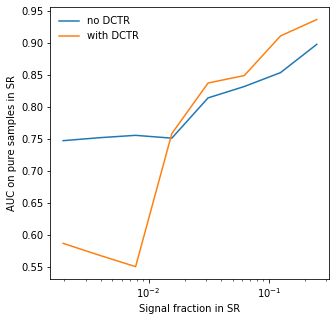

In [200]:
muvals = []
for k in range(2,10):
    muvals += [1./2**k]
    pass
plt.figure(figsize=(5,5)) 
plt.plot(muvals,old,label="no DCTR")
plt.plot(muvals,new,label="with DCTR")
plt.xscale("log")
plt.xlabel("Signal fraction in SR")
plt.ylabel("AUC on pure samples in SR")
plt.legend(frameon=False)
plt.savefig("SensitivityScaling.pdf")

In [201]:
#fprs_old = []
#tprs_old = []
#fprs_new = []
#tprs_new = []

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


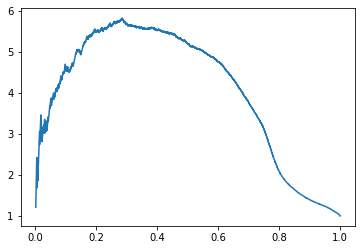

In [204]:
plt.plot(tprs_old[0],tprs_old[0]/fprs_old[0]**0.5)

In [208]:
[max(tprs_old[i][fprs_old[i]>0]/fprs_old[i][fprs_old[i]>0]**0.5) for i in range(len(tprs_old))]

[5.824860459446321,
 4.0115867094998094,
 2.789369480531264,
 2.0049050104155532,
 1.2738063774066672,
 1.2771481575585162,
 1.2850815196535805,
 1.2403276017587288]

In [209]:
[max(tprs_new[i][fprs_new[i]>0]/fprs_new[i][fprs_new[i]>0]**0.5) for i in range(len(tprs_new))]

[12.107266671366114,
 8.013526832208463,
 3.3206627439423078,
 2.804386785152045,
 2.4226590523884974,
 1.0055385135764199,
 1.0011702838654117,
 1.0294037051378306]

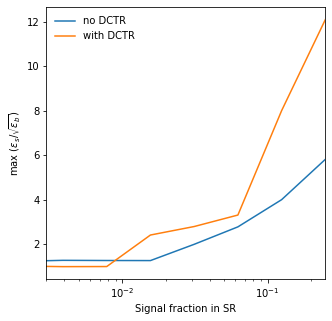

In [217]:
muvals = []
for k in range(2,10):
    muvals += [1./2**k]
    pass
plt.figure(figsize=(5,5)) 
plt.plot(muvals,[max(tprs_old[i][fprs_old[i]>0]/fprs_old[i][fprs_old[i]>0]**0.5) for i in range(len(tprs_old))],label="no DCTR")
plt.plot(muvals,[max(tprs_new[i][fprs_new[i]>0]/fprs_new[i][fprs_new[i]>0]**0.5) for i in range(len(tprs_new))],label="with DCTR")
plt.xscale("log")
plt.xlim([3e-3,0.25])
plt.xlabel("Signal fraction in SR")
plt.ylabel(r"max ($\epsilon_s/\sqrt{\epsilon_b}$)")
plt.legend(frameon=False)
plt.savefig("SignificanceScaling.pdf")

In [224]:
muvals

[0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.2962962962962963,
 0.19753086419753085,
 0.19753086419753085,
 0.19753086419753085,
 0.19753086419753085,
 0.19753086419753085,
 0.19753086419753085,
 0.19753086419753085,
 0.19753086419753085,
 0.19753086419753085,
 0.19753086419753085,
 0.13168724279835392,
 0.13168724279835392,
 0.13168724279835392,
 0.13168724279835392,
 0.13168724279835392,
 0.13168724279835392,
 0.13168724279835392,
 0.13168724279835392,
 0.13168724279835392,
 0.13168724279835392,
 0.0877914951989026,
 0.0877914951989026,
 0.0877914951989026,
 0.0877914951989026,
 0.0877914951989026,
 0.0877914951989026,
 0.0877914951989026,
 0.0877914951989026,
 0.0877914951989026,
 0.0877914951989026,
 0.05852766346593507,
 0.05852766346593507,
 0.05852766346593507,
 0.05852766346593507,
 0.05852766346593507,
 0.05852766346593507,
 0.05852

In [228]:
hold_old = [max(tprs_old[i][fprs_old[i]>0]/fprs_old[i][fprs_old[i]>0]**0.5) for i in range(len(tprs_old))]
hold_new = [max(tprs_new[i][fprs_new[i]>0]/fprs_new[i][fprs_new[i]>0]**0.5) for i in range(len(tprs_new))]

In [231]:
uniquemuvals = []
for mval in muvals:
    if mval in uniquemuvals:
        continue
    uniquemuvals+=[mval]
    pass

In [233]:
holds_old = {}
holds_new = {}
for umval in uniquemuvals:
    holds_old[umval] = []
    holds_new[umval] = []
    pass
for i in range(len(muvals)):
    holds_old[muvals[i]]+=[hold_old[i]]
    holds_new[muvals[i]]+=[hold_new[i]]
    pass

In [237]:
yvals_new = np.array([np.mean(holds_new[mykey]) for mykey in holds_new])
yvals_old = np.array([np.mean(holds_old[mykey]) for mykey in holds_old])
eyvals_new = np.array([np.std(holds_new[mykey]) for mykey in holds_new])
eyvals_old = np.array([np.std(holds_old[mykey]) for mykey in holds_old])

In [242]:
yvals_new0 = np.mean(holds_new[0.])
yvals_old0 = np.mean(holds_old[0.])
eyvals_new0 = np.std(holds_new[0.])
eyvals_old0 = np.std(holds_old[0.])

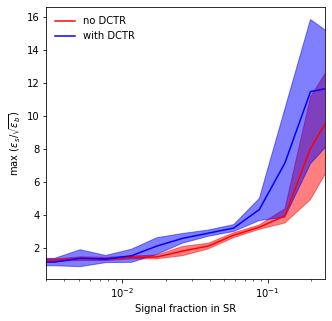

In [250]:
plt.figure(figsize=(5,5)) 
plt.plot(uniquemuvals,yvals_old,label="no DCTR",color="red")
plt.fill_between(uniquemuvals, yvals_old-eyvals_old, yvals_old+eyvals_old,alpha=0.5,color='red')
plt.plot(uniquemuvals,yvals_new,label="with DCTR",color='blue')
plt.fill_between(uniquemuvals, yvals_new-eyvals_new, yvals_new+eyvals_new,alpha=0.5,color='blue')
#plt.plot([3e-3,0.25],[yvals_new0,yvals_new0],ls=":",color="blue")
#plt.plot([3e-3,0.25],[yvals_old0,yvals_old0],ls=":",color="red")
plt.xscale("log")
plt.xlim([3e-3,0.25])
plt.xlabel("Signal fraction in SR")
plt.ylabel(r"max ($\epsilon_s/\sqrt{\epsilon_b}$)")
plt.legend(frameon=False,loc='upper left')
plt.savefig("SignificanceScaling_witherror.pdf")

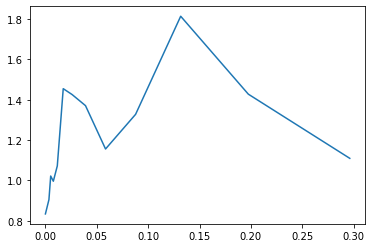

In [249]:
plt.plot(uniquemuvals,yvals_new/yvals_old)